In [1]:
import os

def change_dir_in_hipergator():
    # this env var is set on hipergator (SLURM is the job scheduler there)
    if os.getenv("SLURM_JOB_ID", None):
        target_dir = "diff_fam_social_memory_ephys"
        current = os.getcwd()

        while True:
            parent = os.path.dirname(current)
            # If we've reached the root directory without finding the target
            if parent == current:
                raise FileNotFoundError(f"Could not find parent directory '{target_dir}'")

            # Check if the target directory is the current parent's name
            if os.path.basename(parent) == target_dir:
                os.chdir(parent)
                return parent

            current = parent

# Usage
try:
    new_path = change_dir_in_hipergator()
    print(f"Successfully changed to directory: {new_path}")
except FileNotFoundError as e:
    print(e)

Successfully changed to directory: None


In [2]:
import pandas as pd
import numpy as np
import lfp.lfp_analysis.LFP_collection as LFP_collection
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import cm
from matplotlib.ticker import ScalarFormatter
import lfp.lfp_analysis.plotting as lfplt
from itertools import combinations, permutations
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from importlib import reload
from lfp.lfp_analysis.LFP_collection import LFPCollection
import math
from scipy import stats
import lfp.lfp_analysis.preprocessor as preprocessor
import lfp.lfp_analysis.connectivity_wrapper as connect
from scipy.interpolate import interp1d
from importlib import reload
import os

MEDIAN_ZSCORE_MULTIPLIER = 0.6745

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl
    Returns:
        none
    """
    with open(file_name, "wb") as file:
        pickle.dump(thing_to_pickle, file)


def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, "rb") as file:
        return pickle.load(file)
    


object_control_lfp_json = r"C:\Users\megha\UFL Dropbox\Meghan Cum\Padilla-Coreano Lab\2024\Cum_SocialMemEphys_pilot2\Object_Control (phase 7)\lfp_data\lfp_collection.json"

object_collection = LFP_collection.LFPCollection.load_collection(object_control_lfp_json)





# test_rec = object_collection.lfp_recordings[0]
# object_collection.brain_region_dict = test_rec.brain_region_dict

c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
target_dict = {'1.1': ['BLA'],
              '1.2': ['NAc'],
              '1.3': ['BLA'],
              '2.1': [],
              '2.2': ['vHPC'],
              '2.3': ['mPFC', 'vHPC'],
              '2.4': ['MD'],
              '3.1': [],
              '3.2': [],
              '3.3': ['MD'],
              '4.1': [],
              '4.4': ['NAc']}
object_collection.exclude_regions(target_dict)

object_collection.interpolate()



             

In [4]:
behavior_dicts = unpickle_this('pilot2/object_control/object_behavior_dicts.pkl')


    
for recording, behavior_dict in behavior_dicts.items():
    filename = recording.split('_')[0]
    for recording in object_collection.recordings:
        if recording.name.split('_')[0] == filename:
            recording.set_event_dict(behavior_dict)

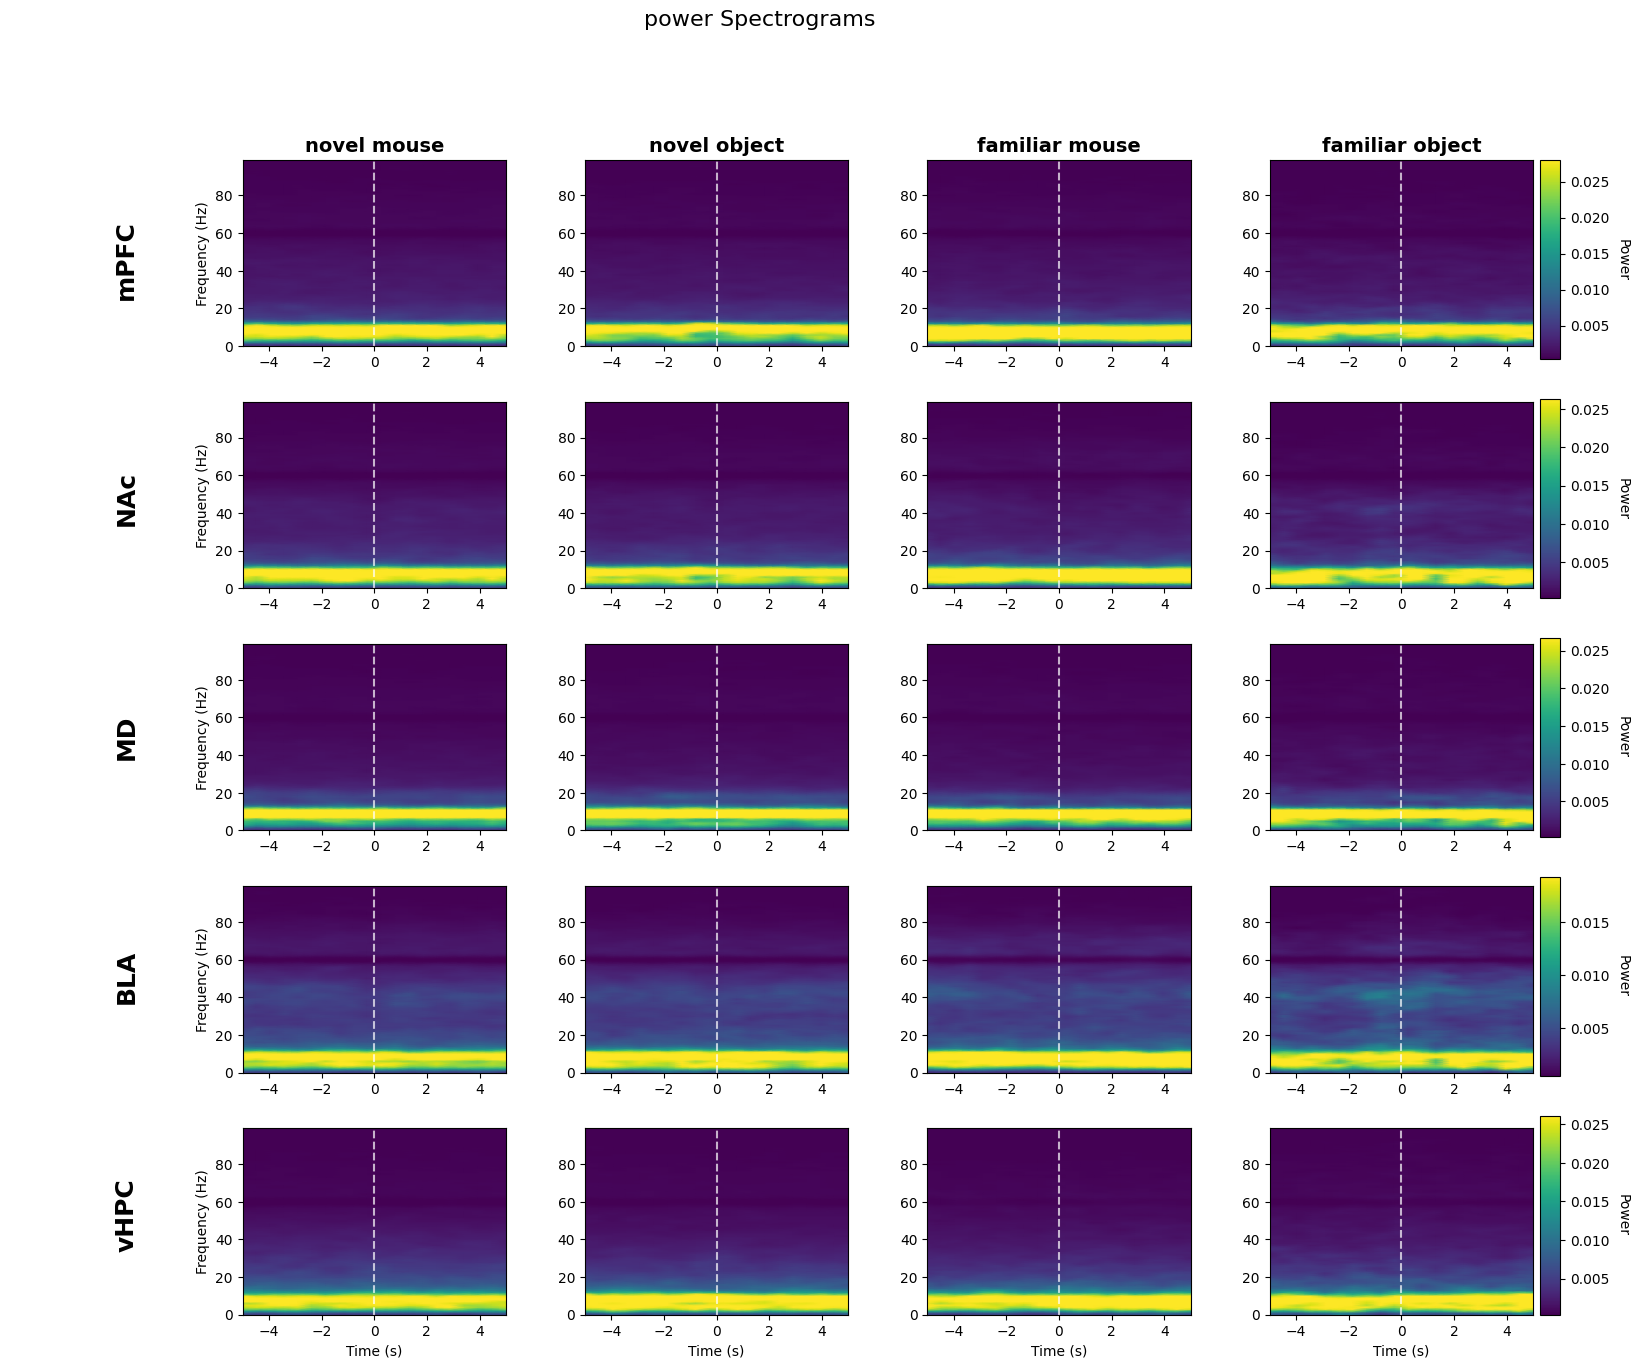

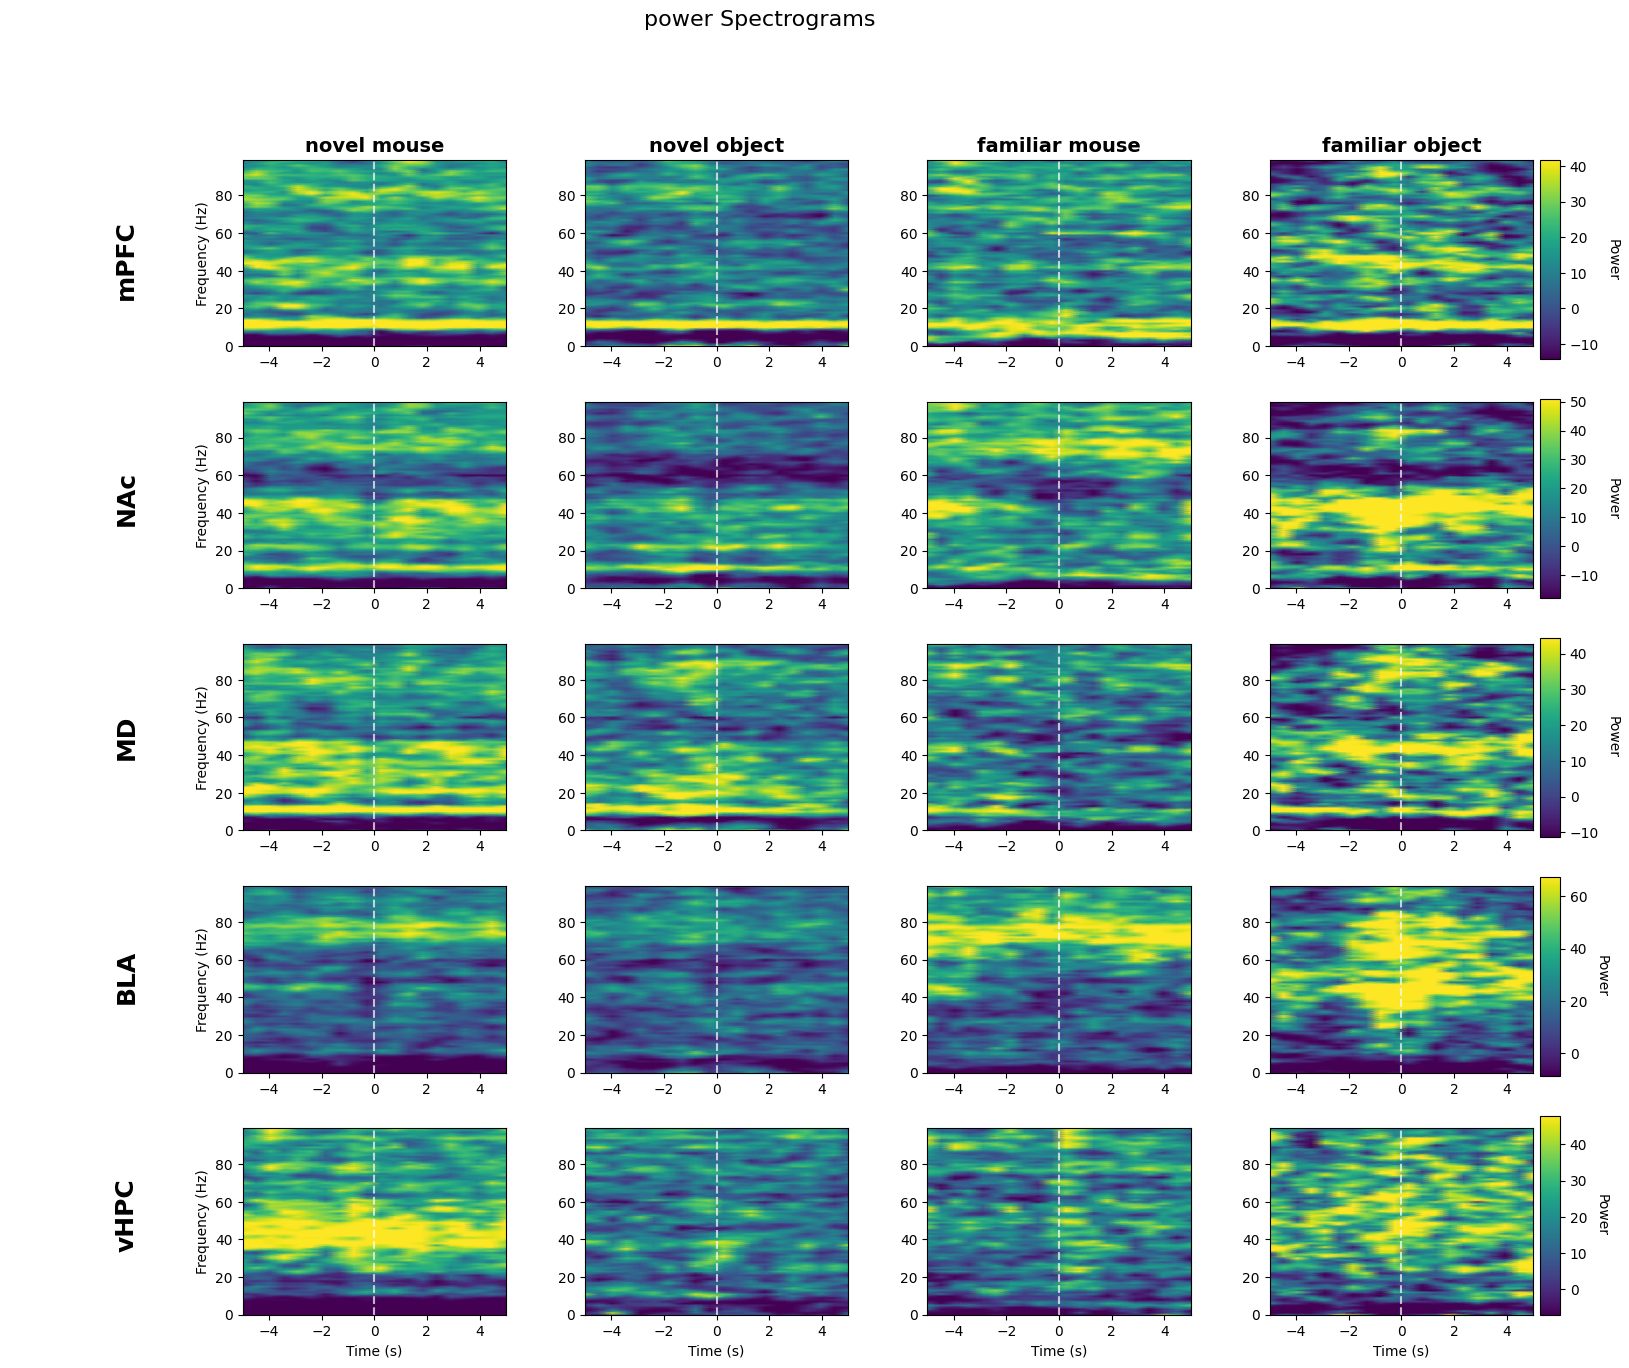

In [5]:
reload(lfplt)
lfplt.plot_spectrogram(object_collection, events = ['novel mouse', 'novel object', 'familiar mouse', 'familiar object'], mode = 'power', event_len = 5, pre_window =5)
lfplt.plot_spectrogram(object_collection, events = ['novel mouse', 'novel object', 'familiar mouse', 'familiar object'], mode = 'power', event_len = 5, pre_window =5, baseline = ['baseline', 'baseline', 'baseline', 'baseline'])

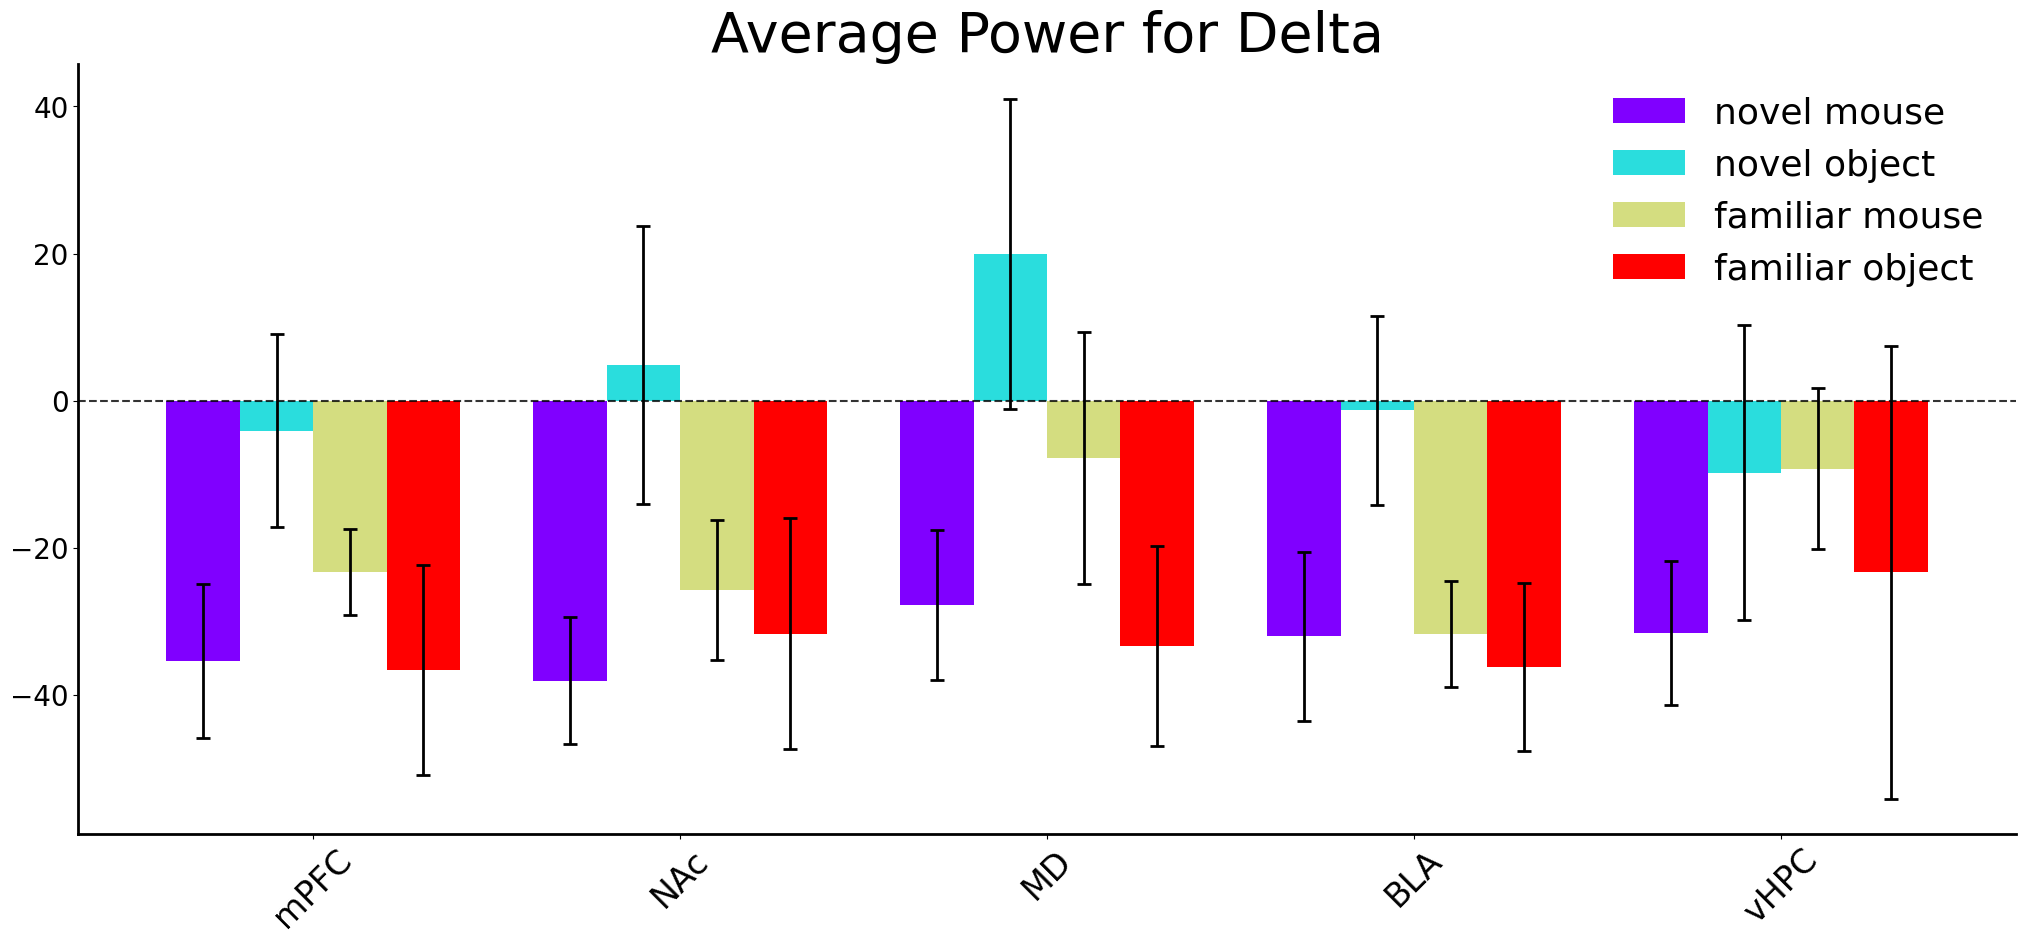

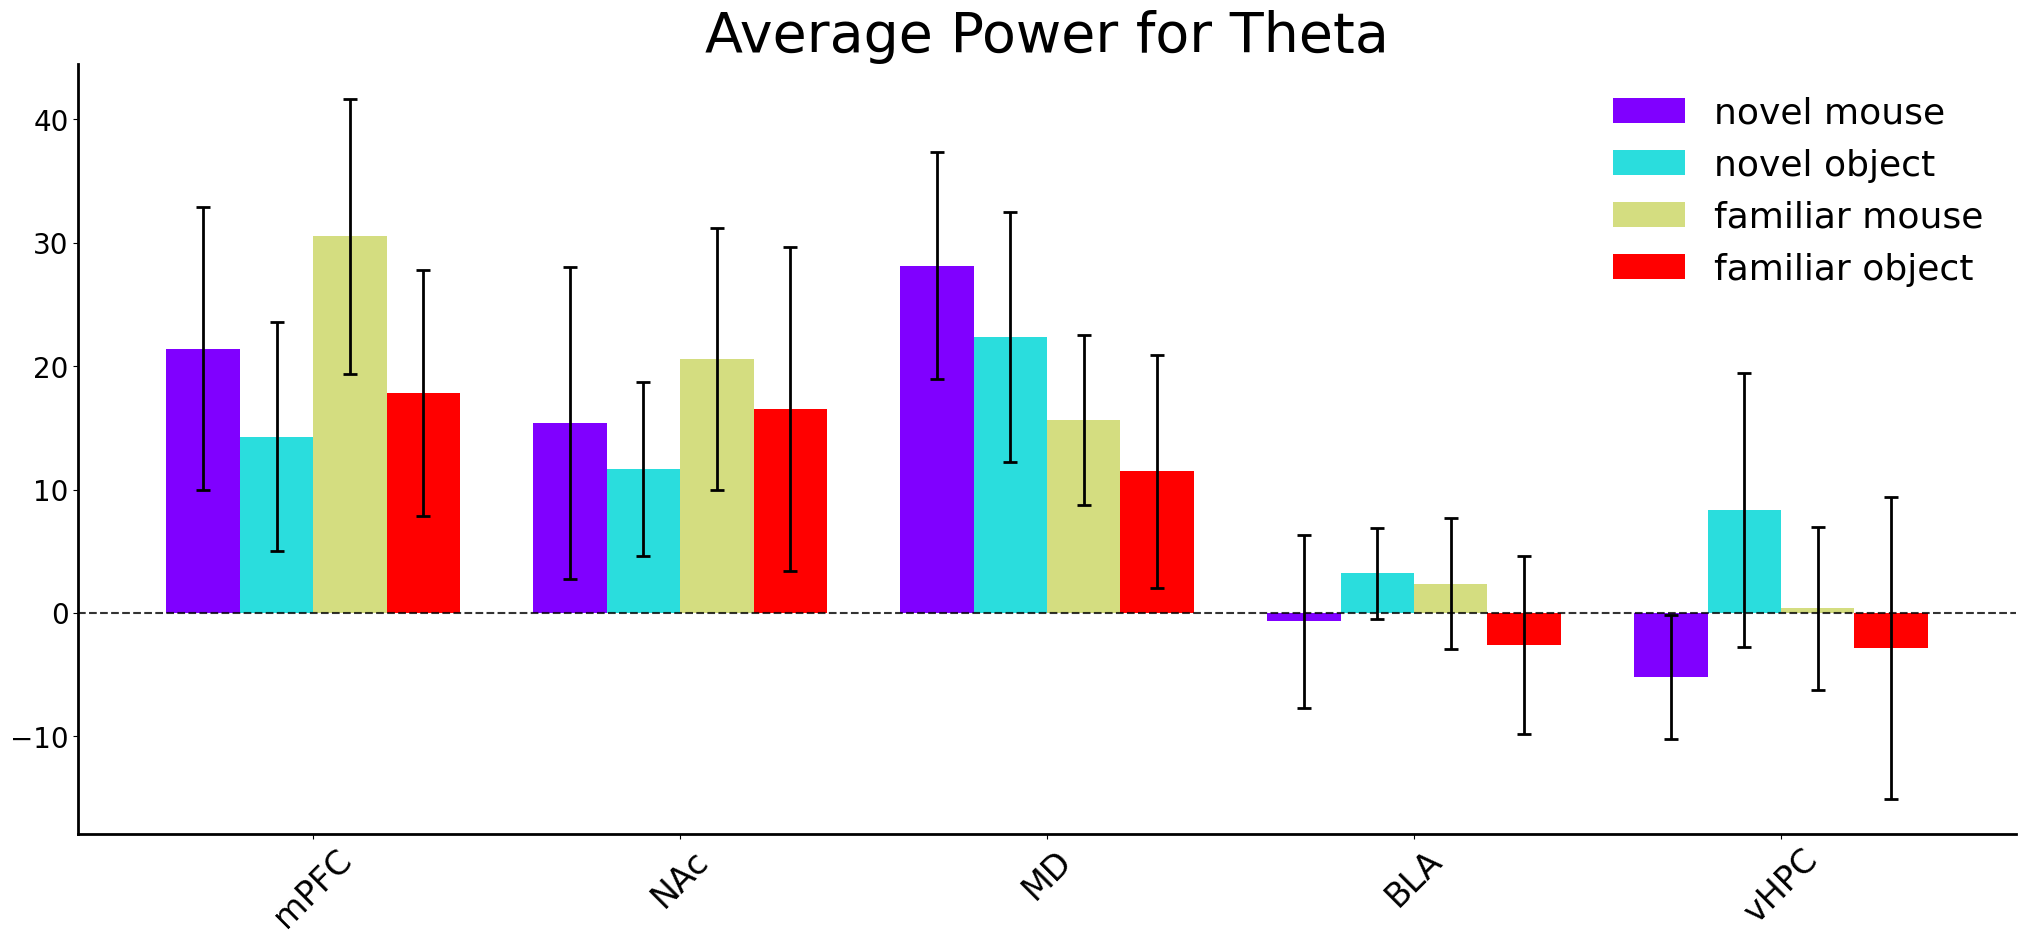

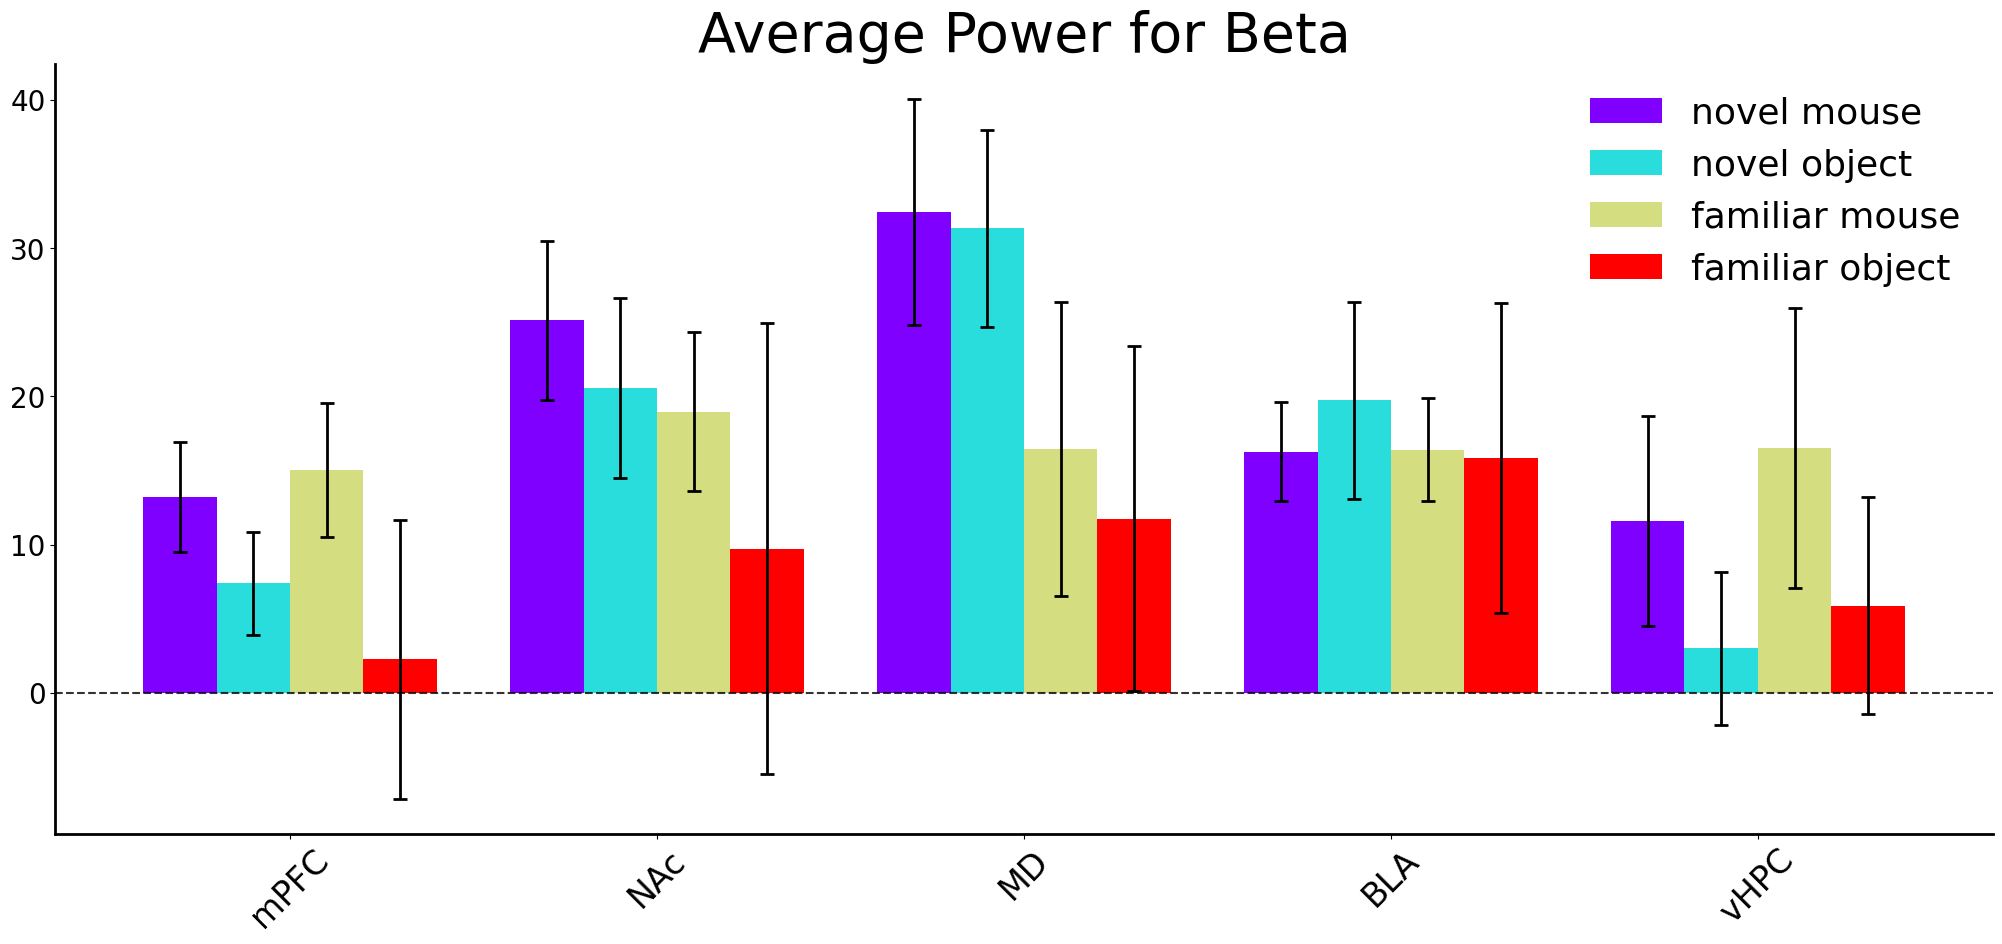

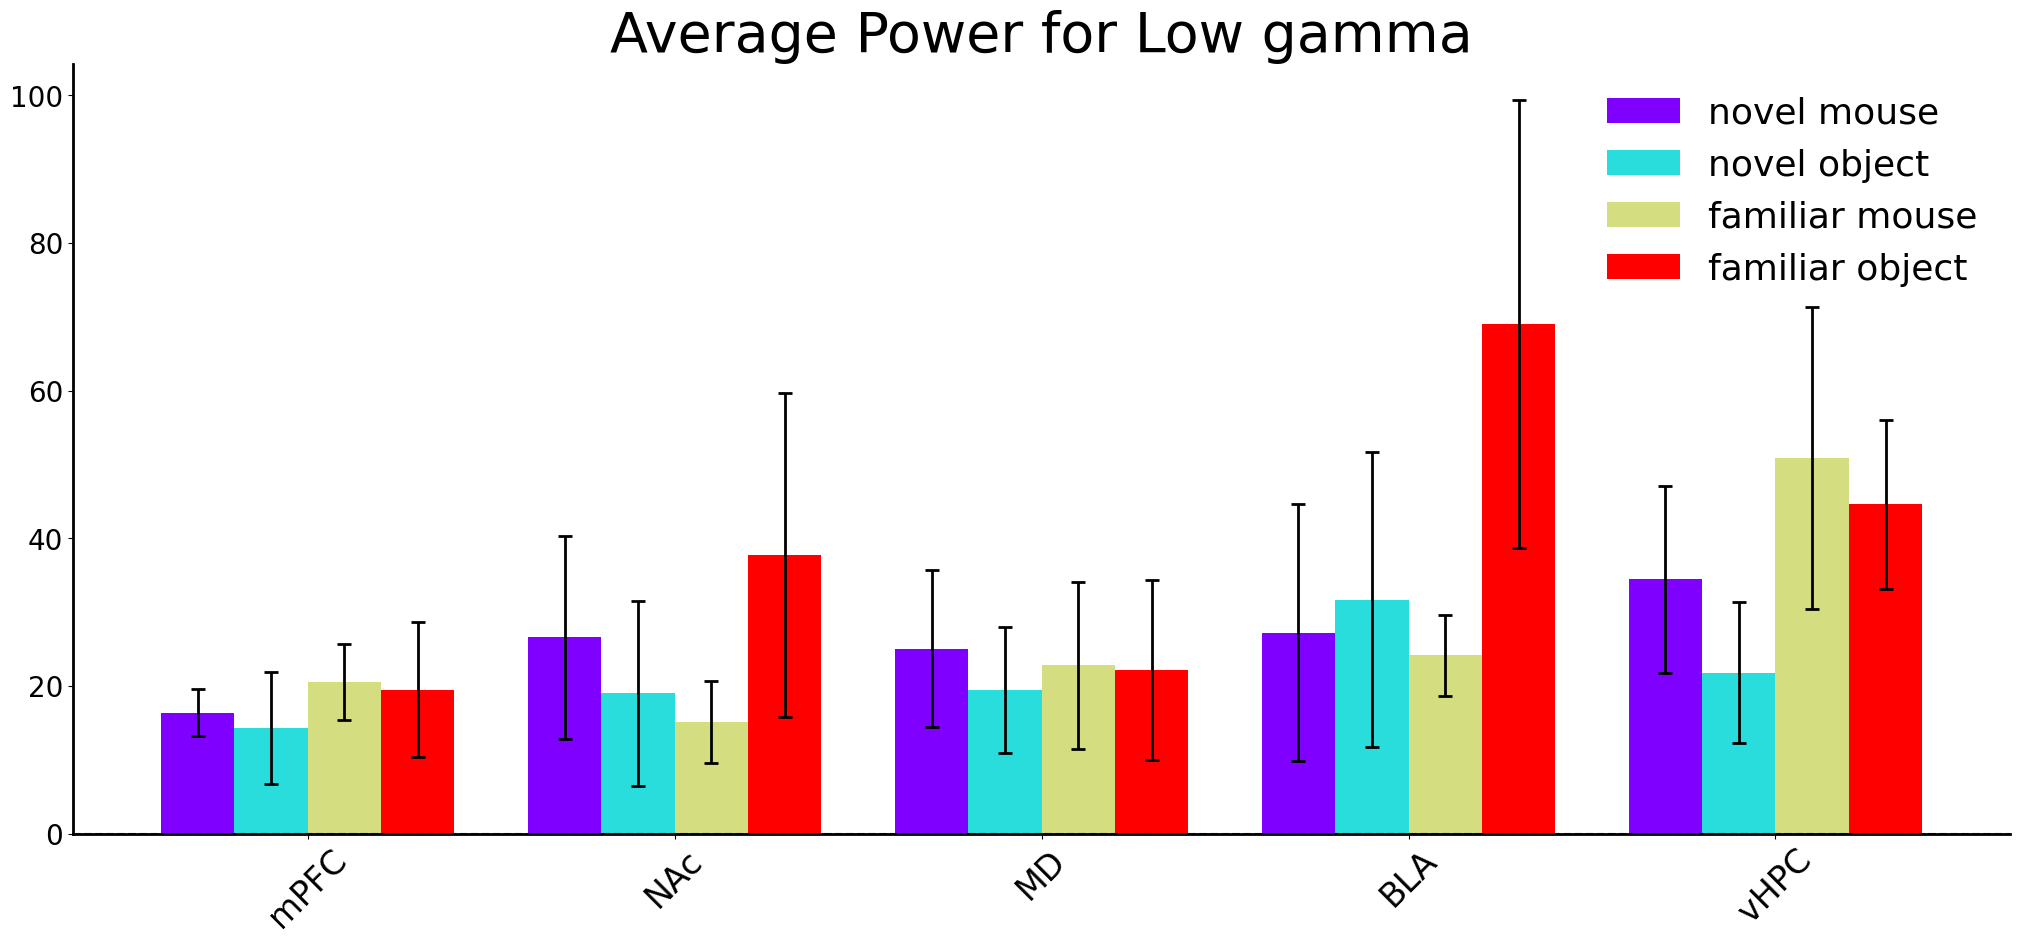

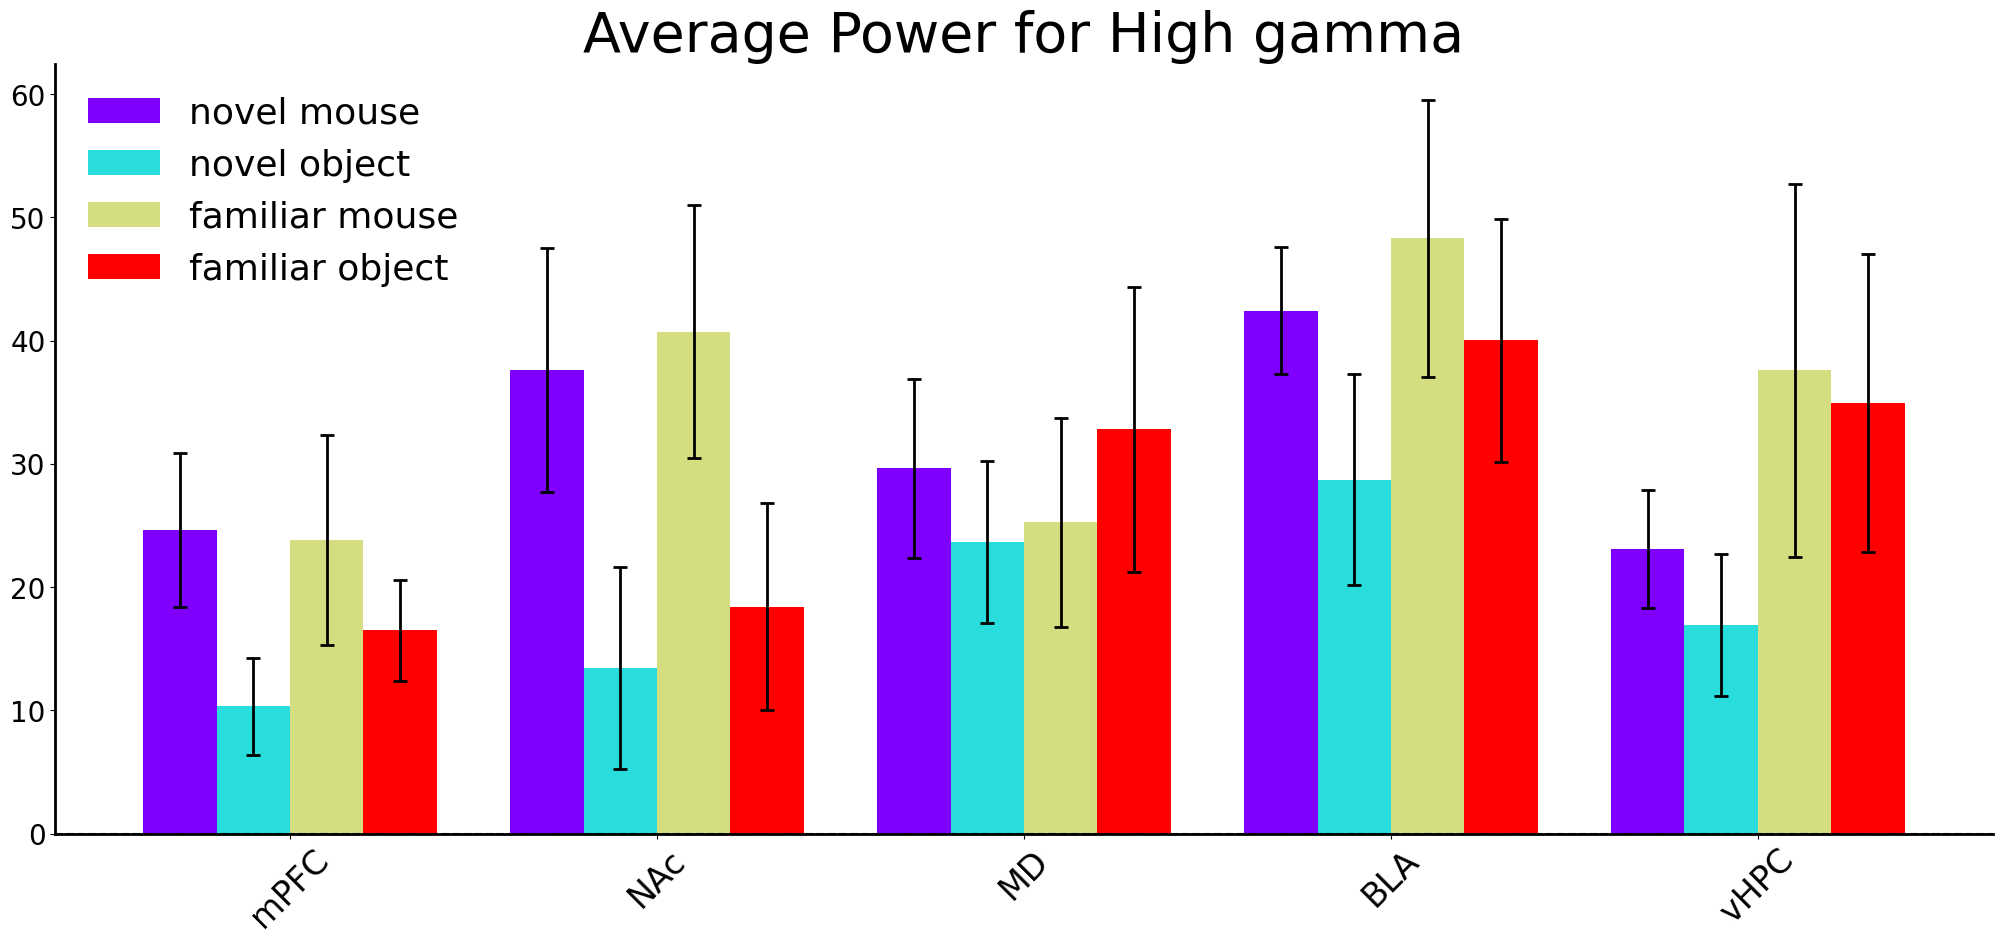

In [6]:
lfplt.event_power_bar(object_collection, events = ['novel mouse', 'novel object', 'familiar mouse', 'familiar object'], baseline = ['baseline', 'baseline', 'baseline', 'baseline'])

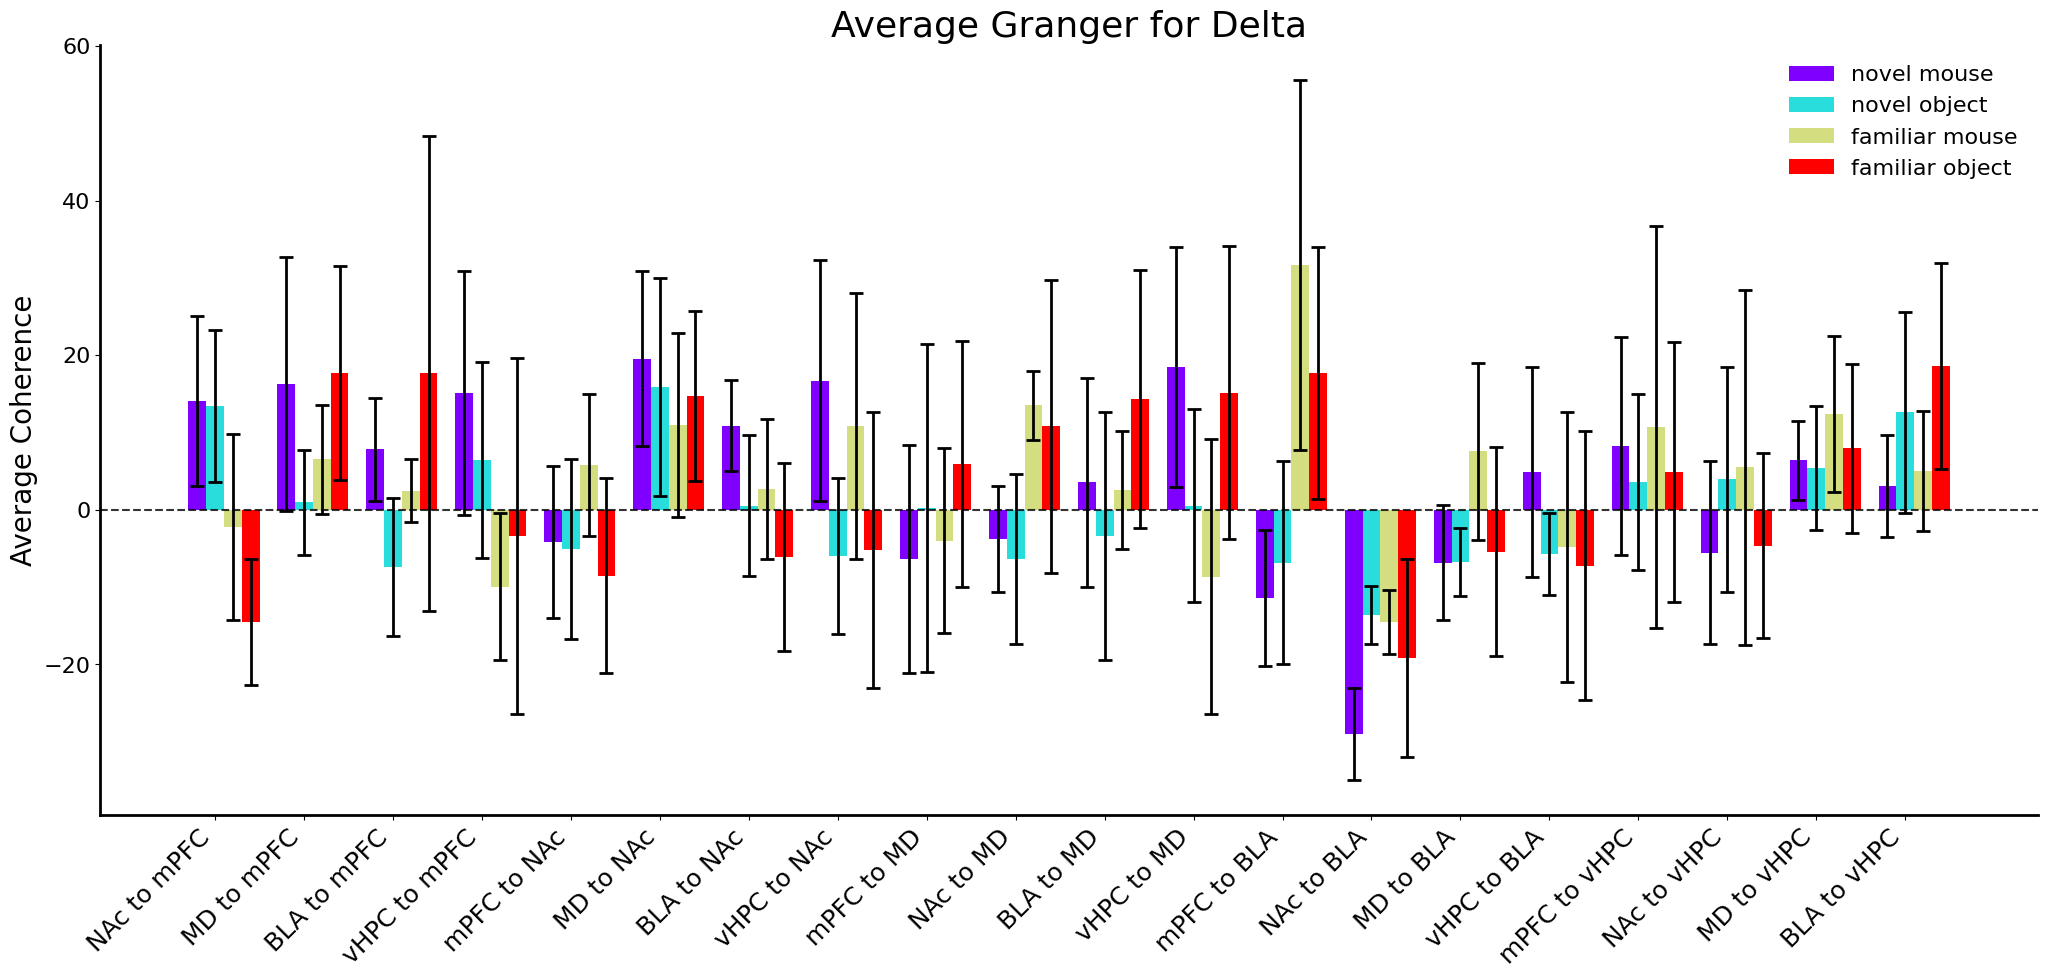

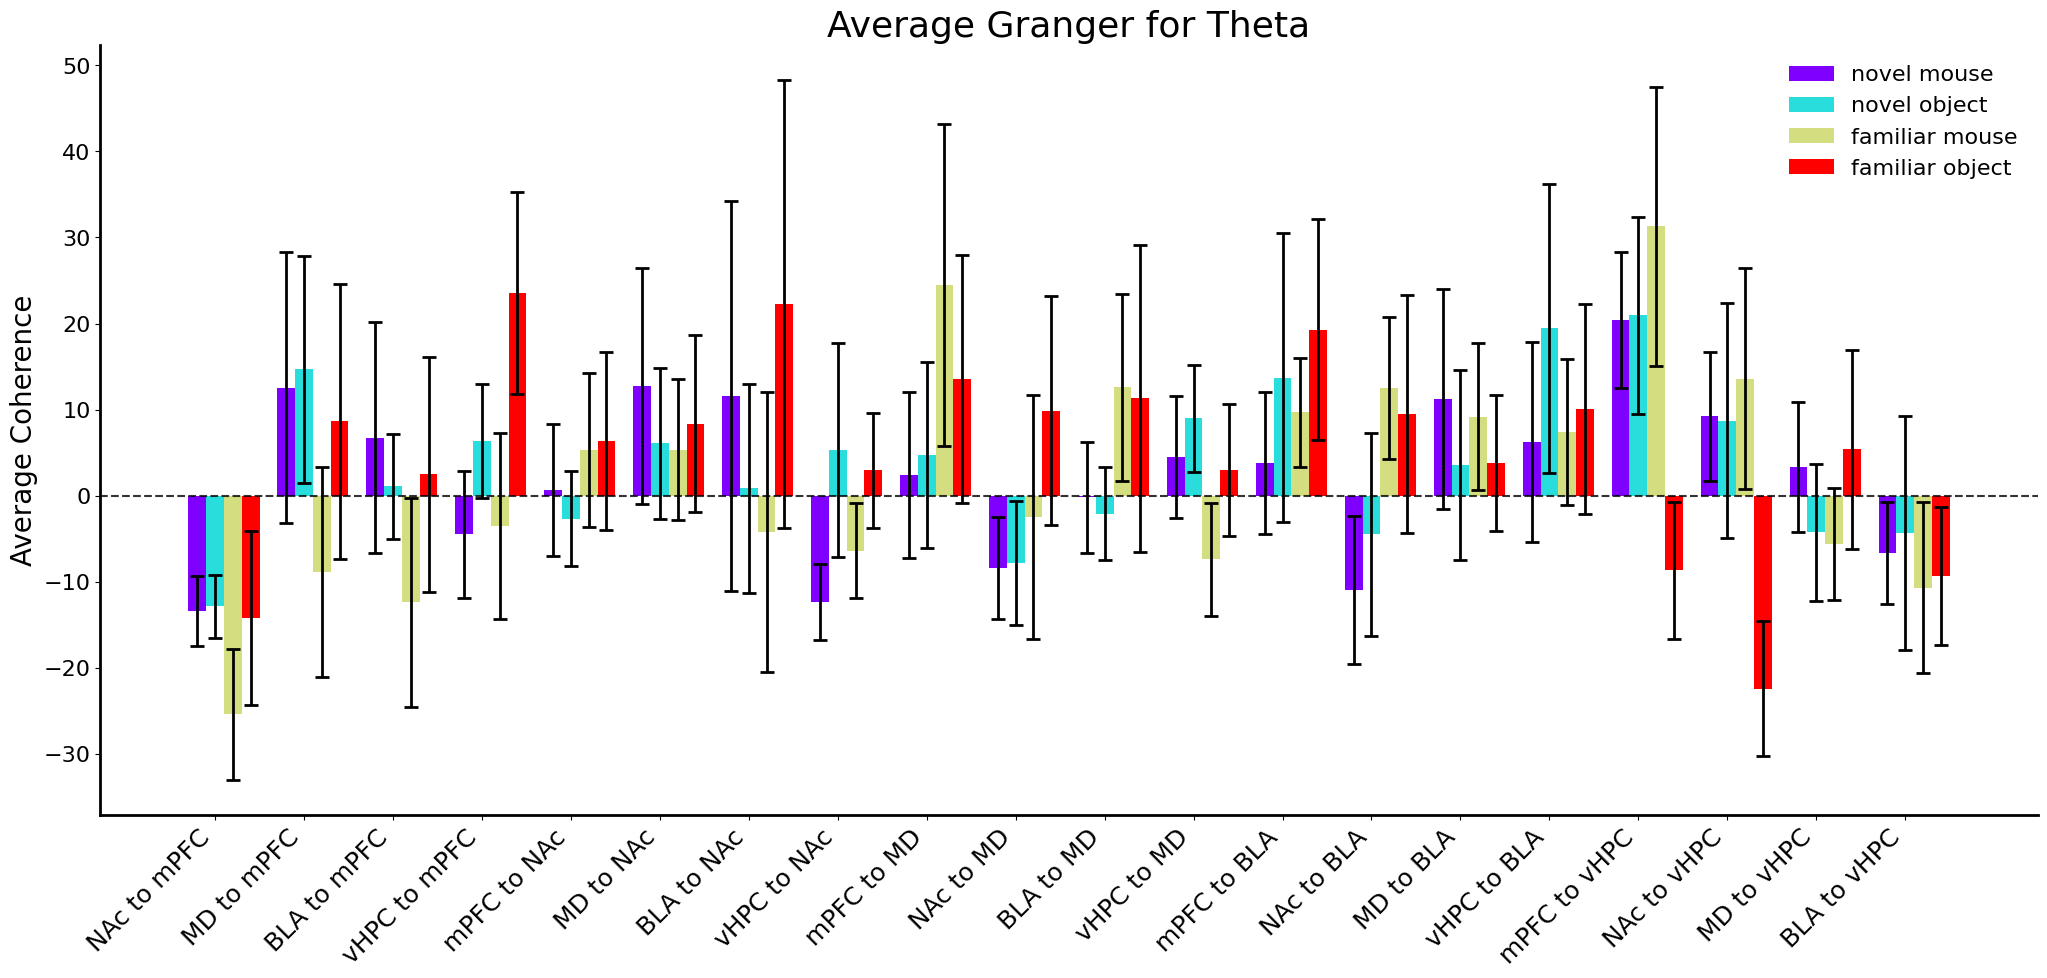

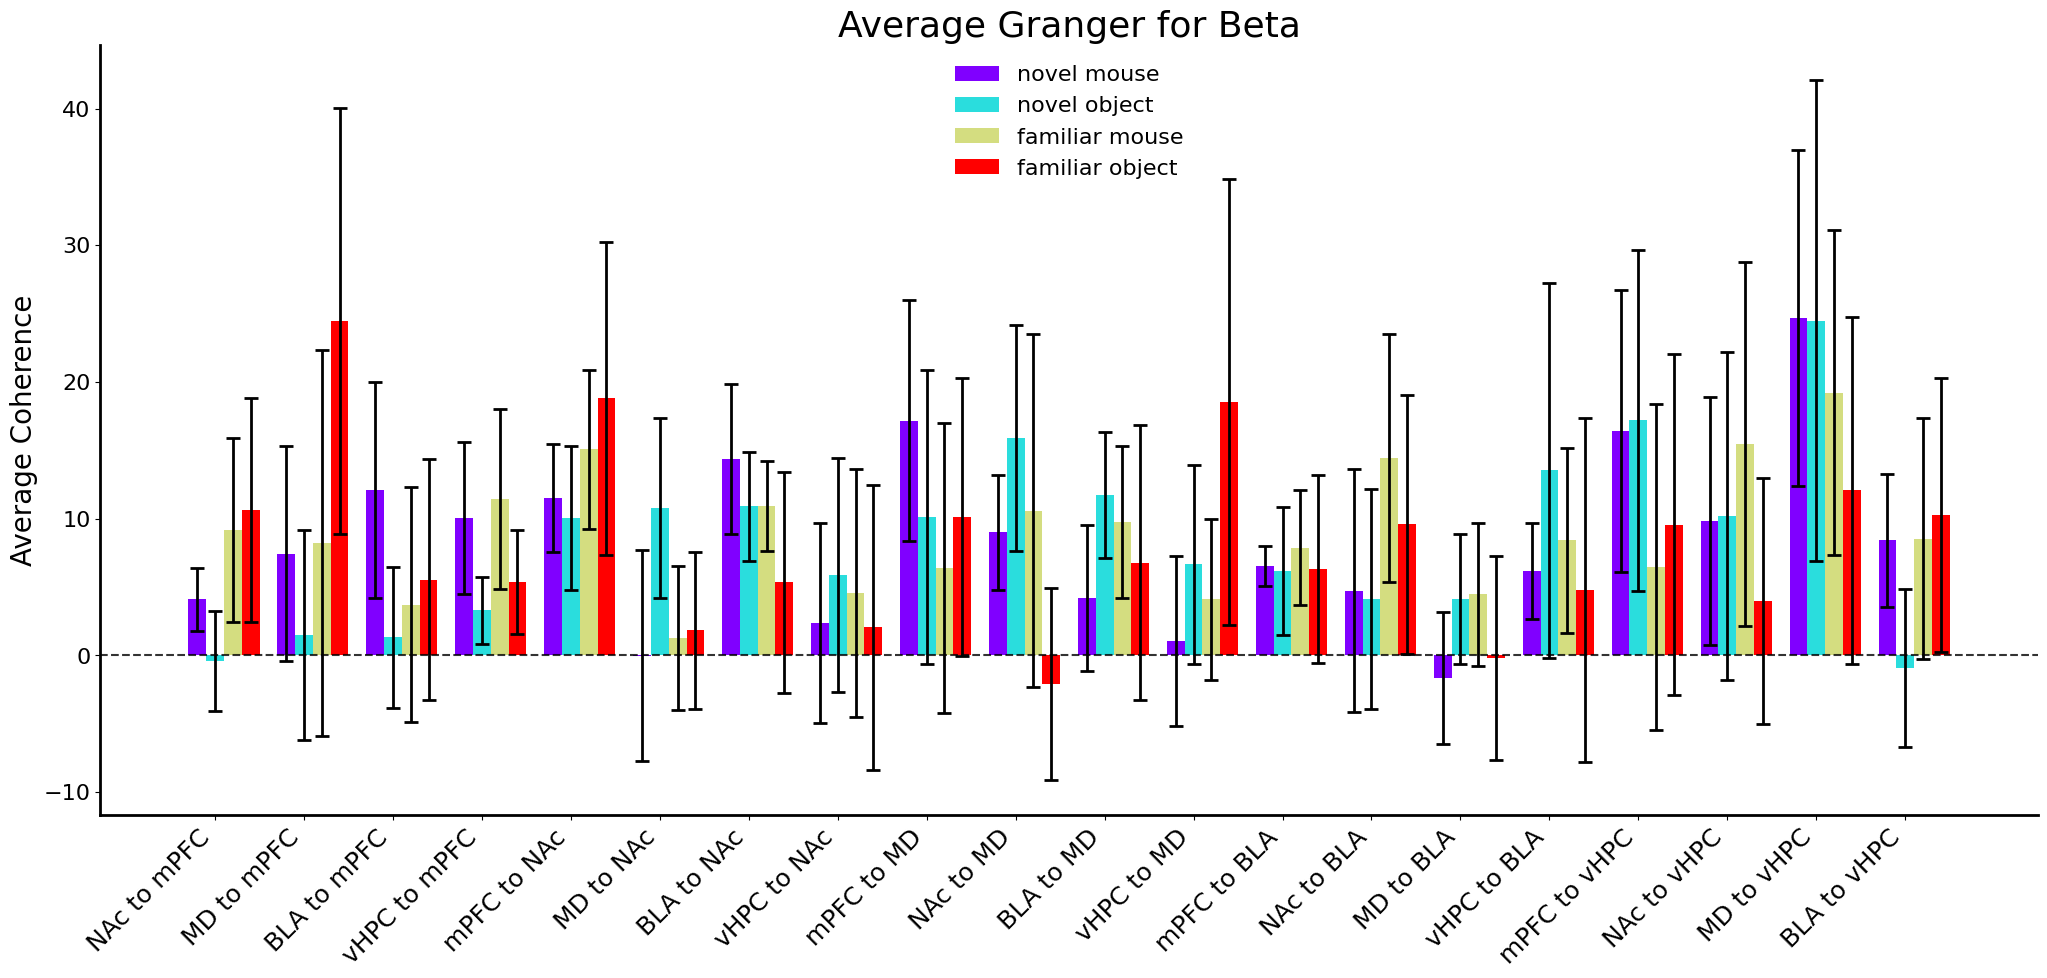

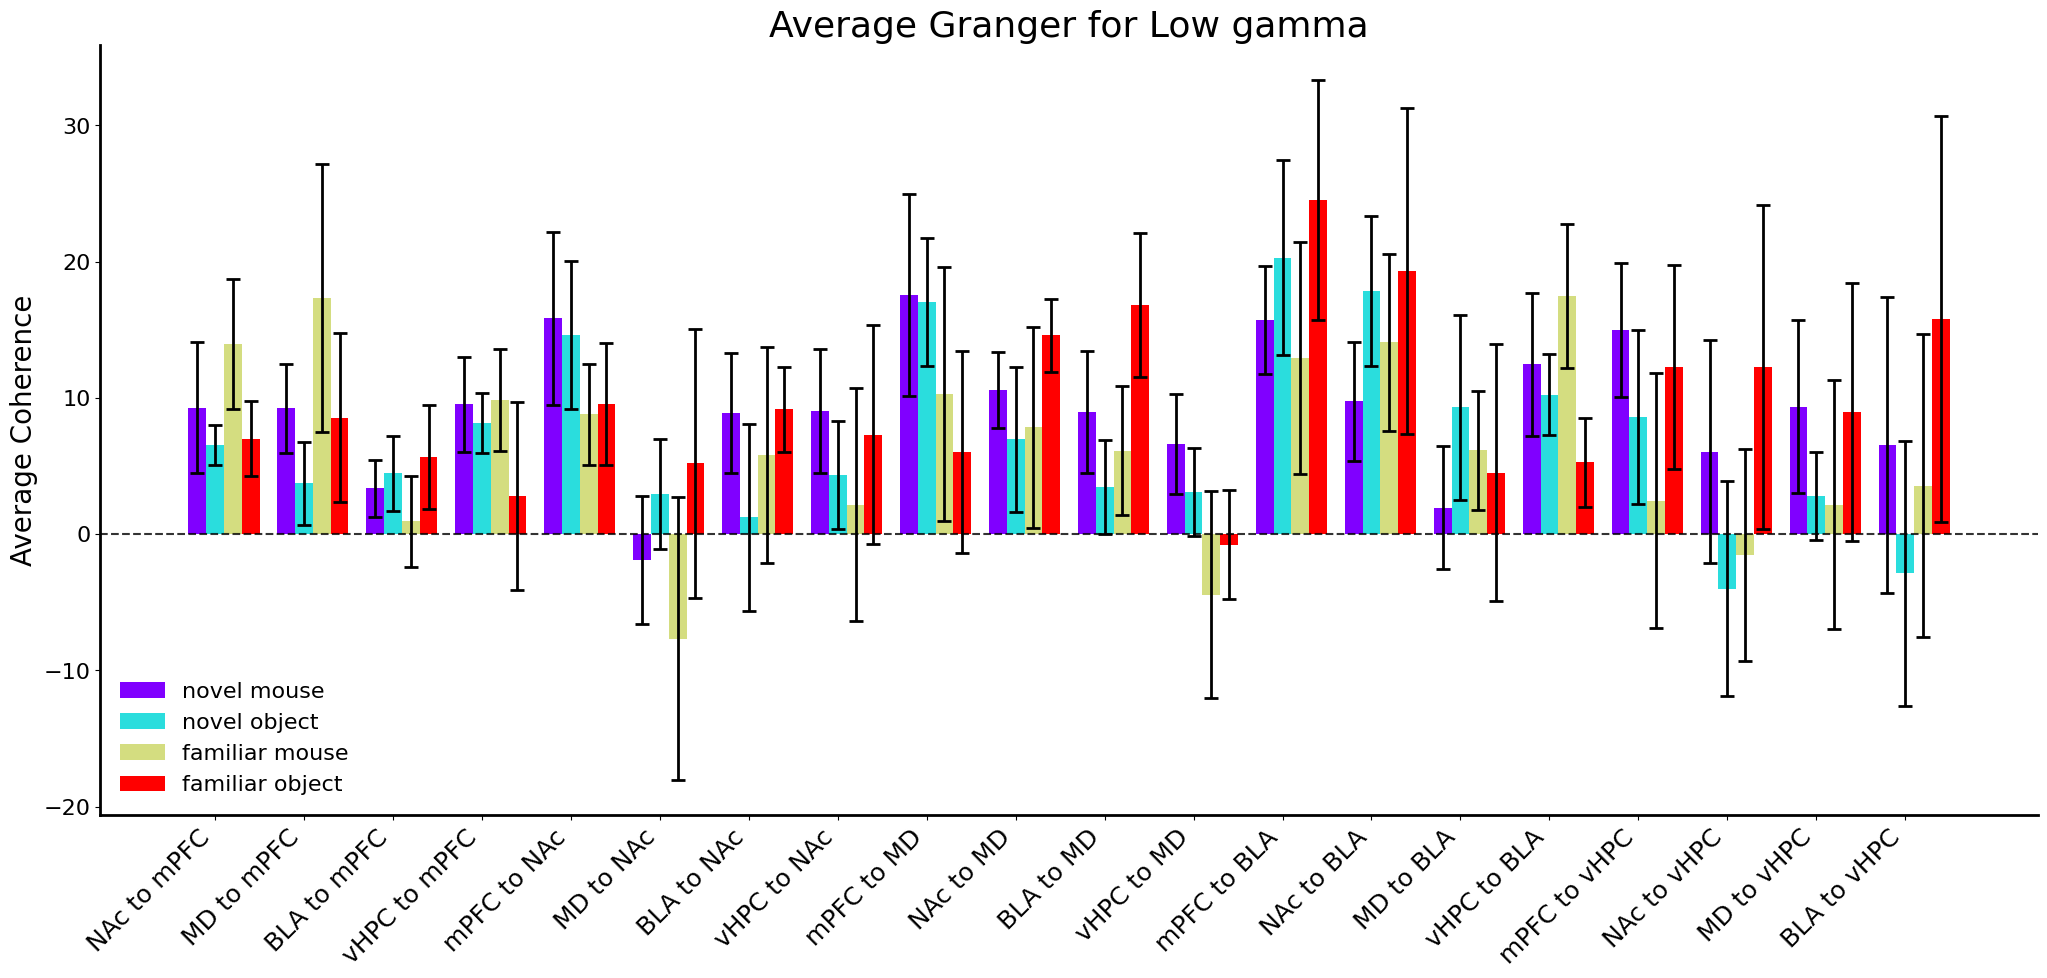

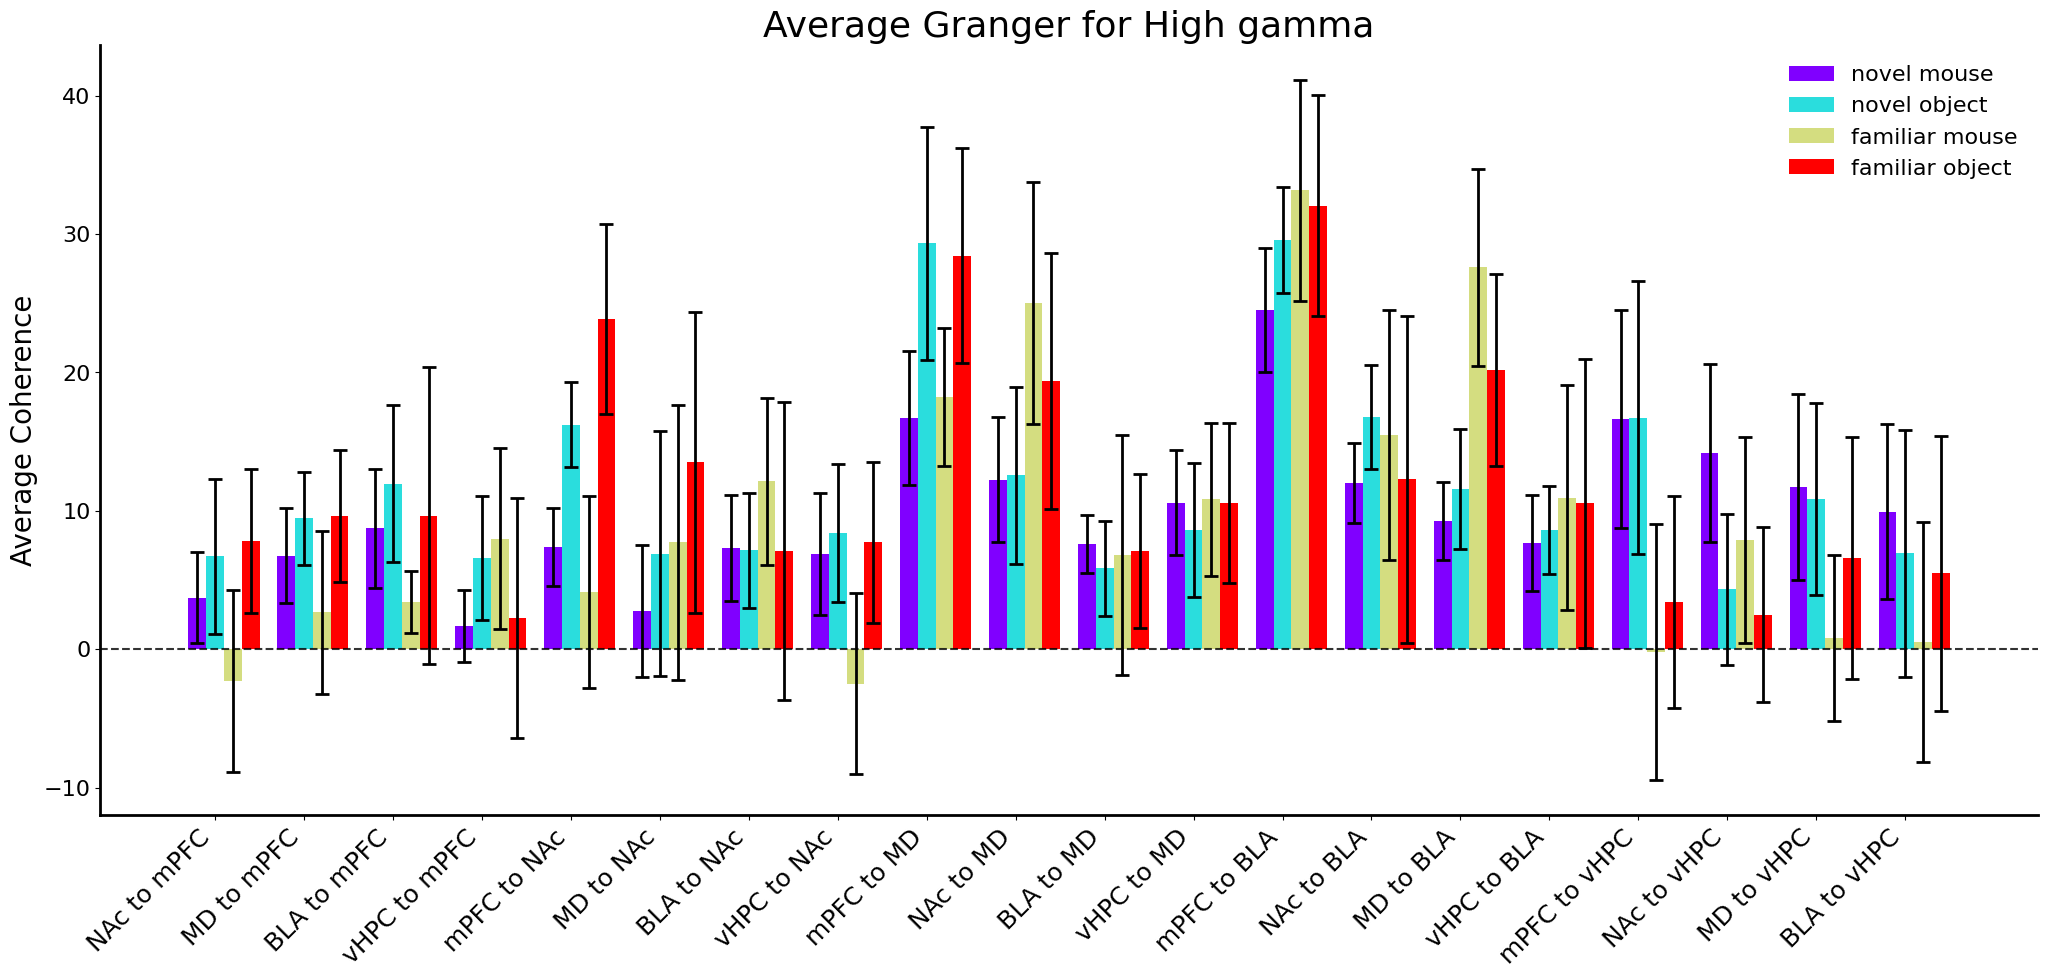

In [7]:
lfplt.event_granger_bar(object_collection, events =  ['novel mouse', 'novel object', 'familiar mouse', 'familiar object'], baseline = ['baseline', 'baseline', 'baseline', 'baseline'])

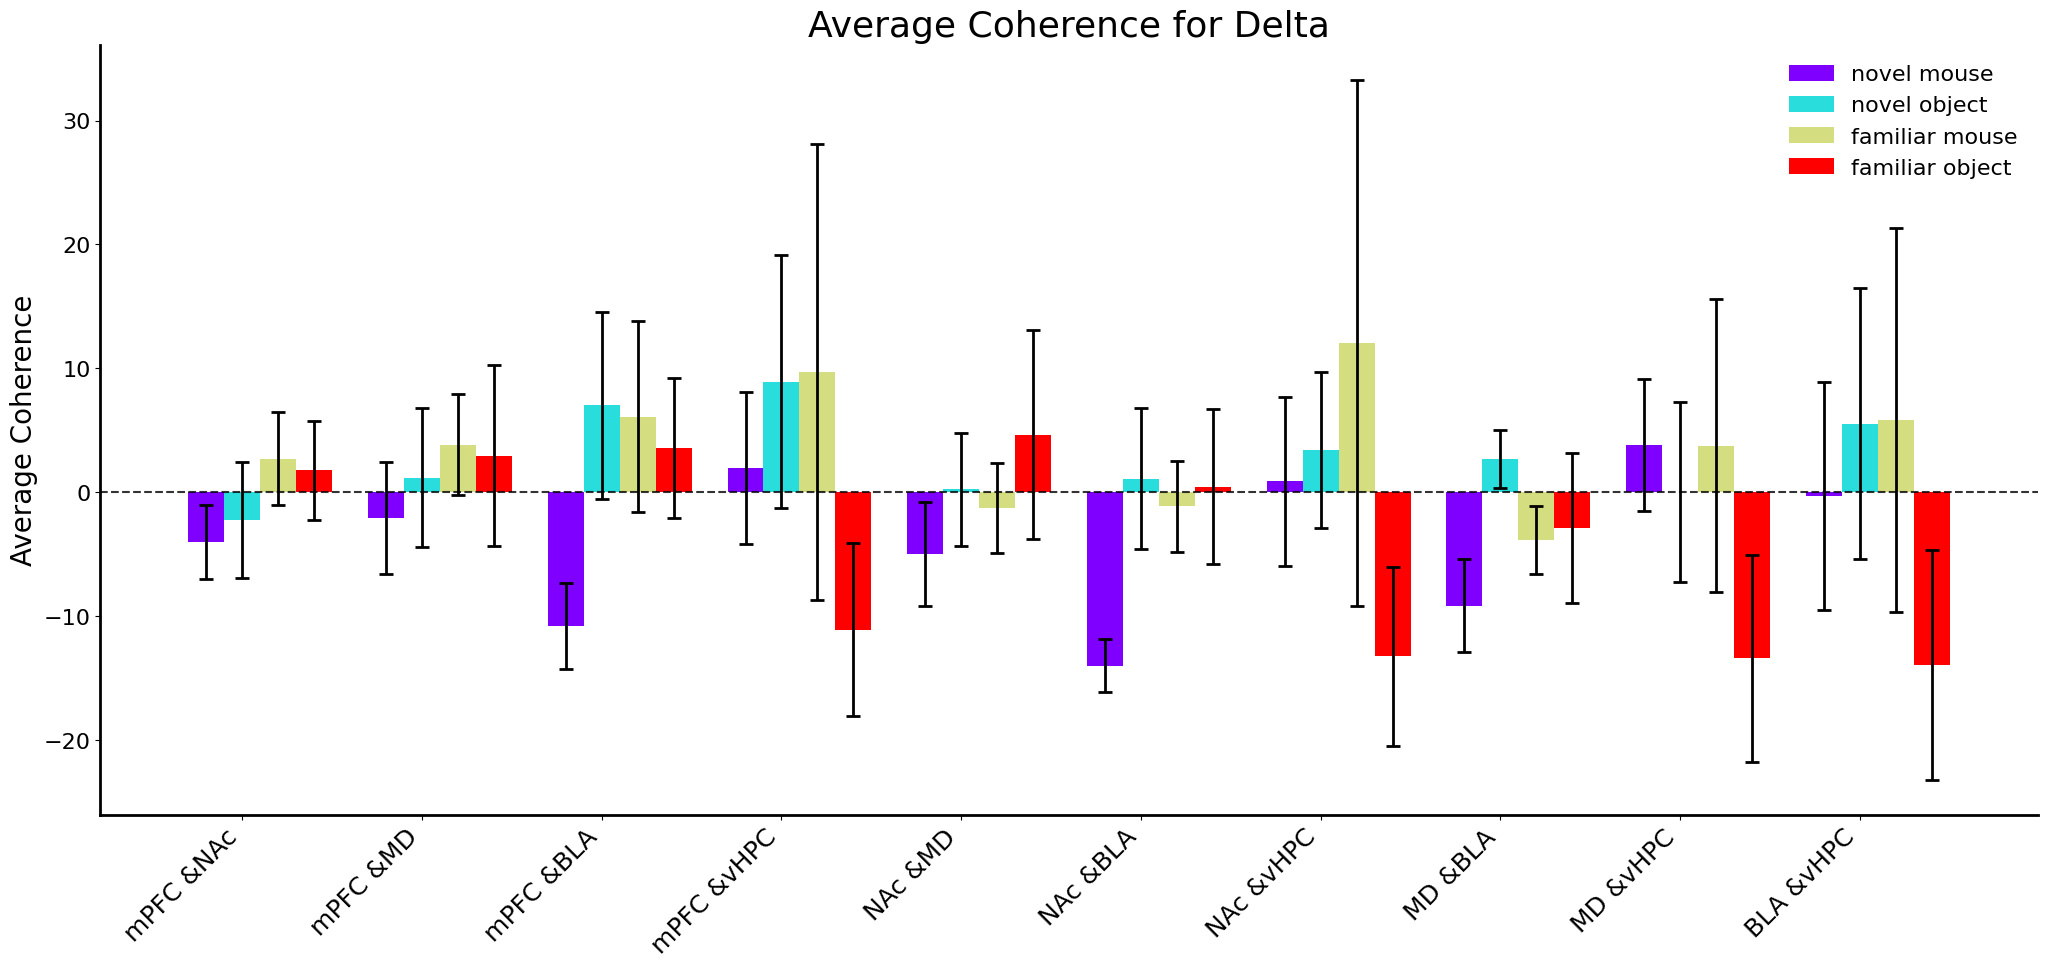

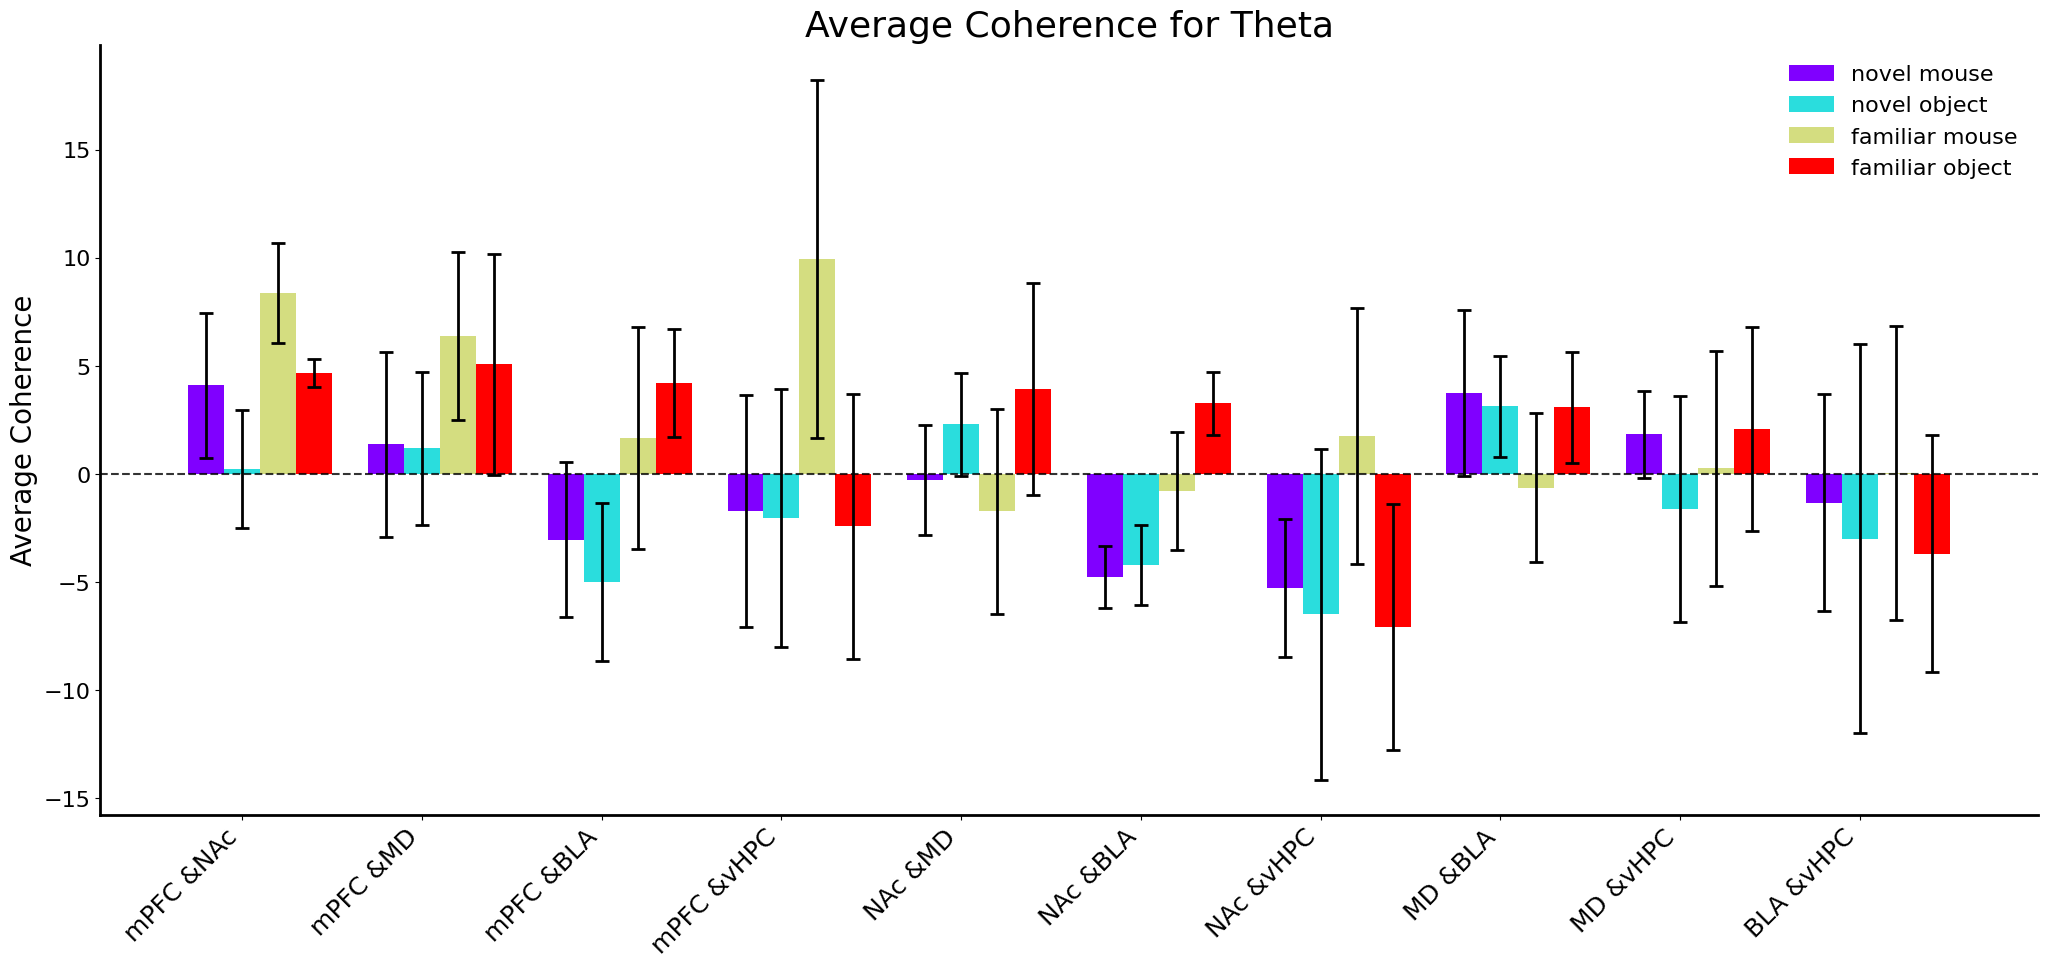

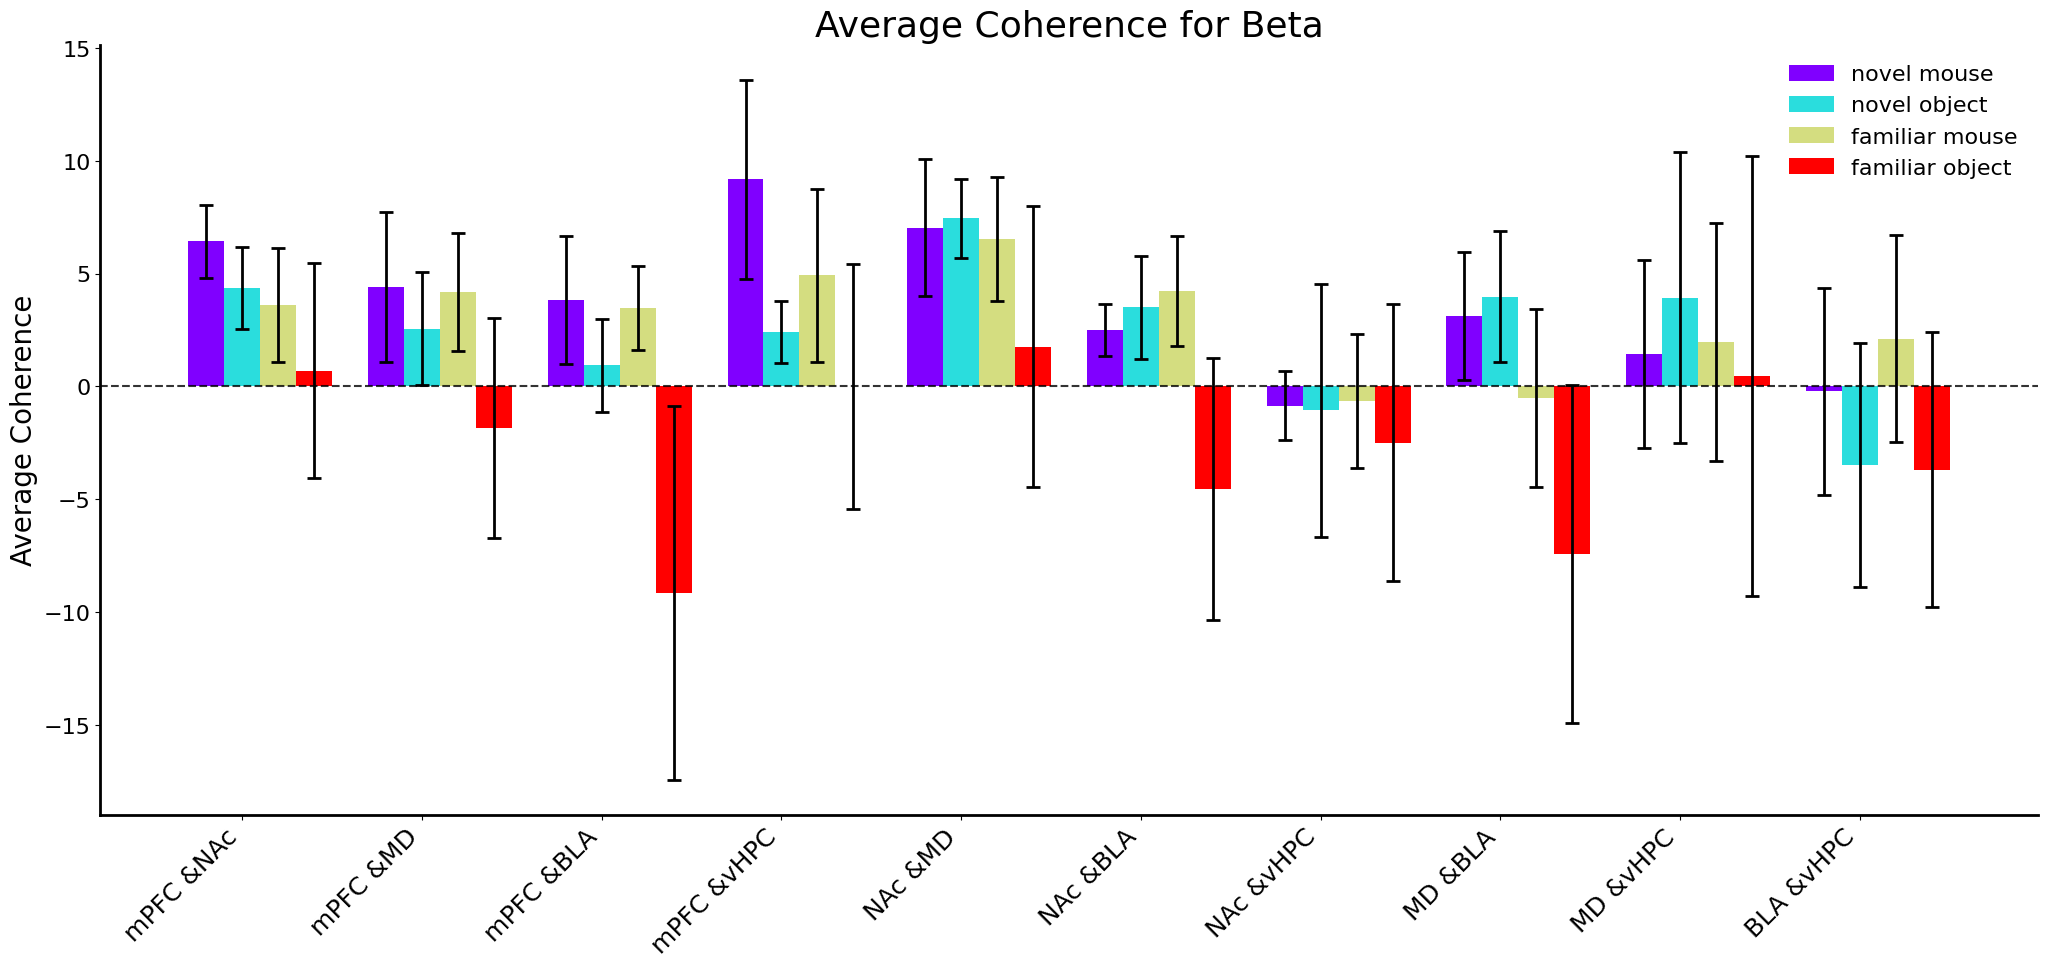

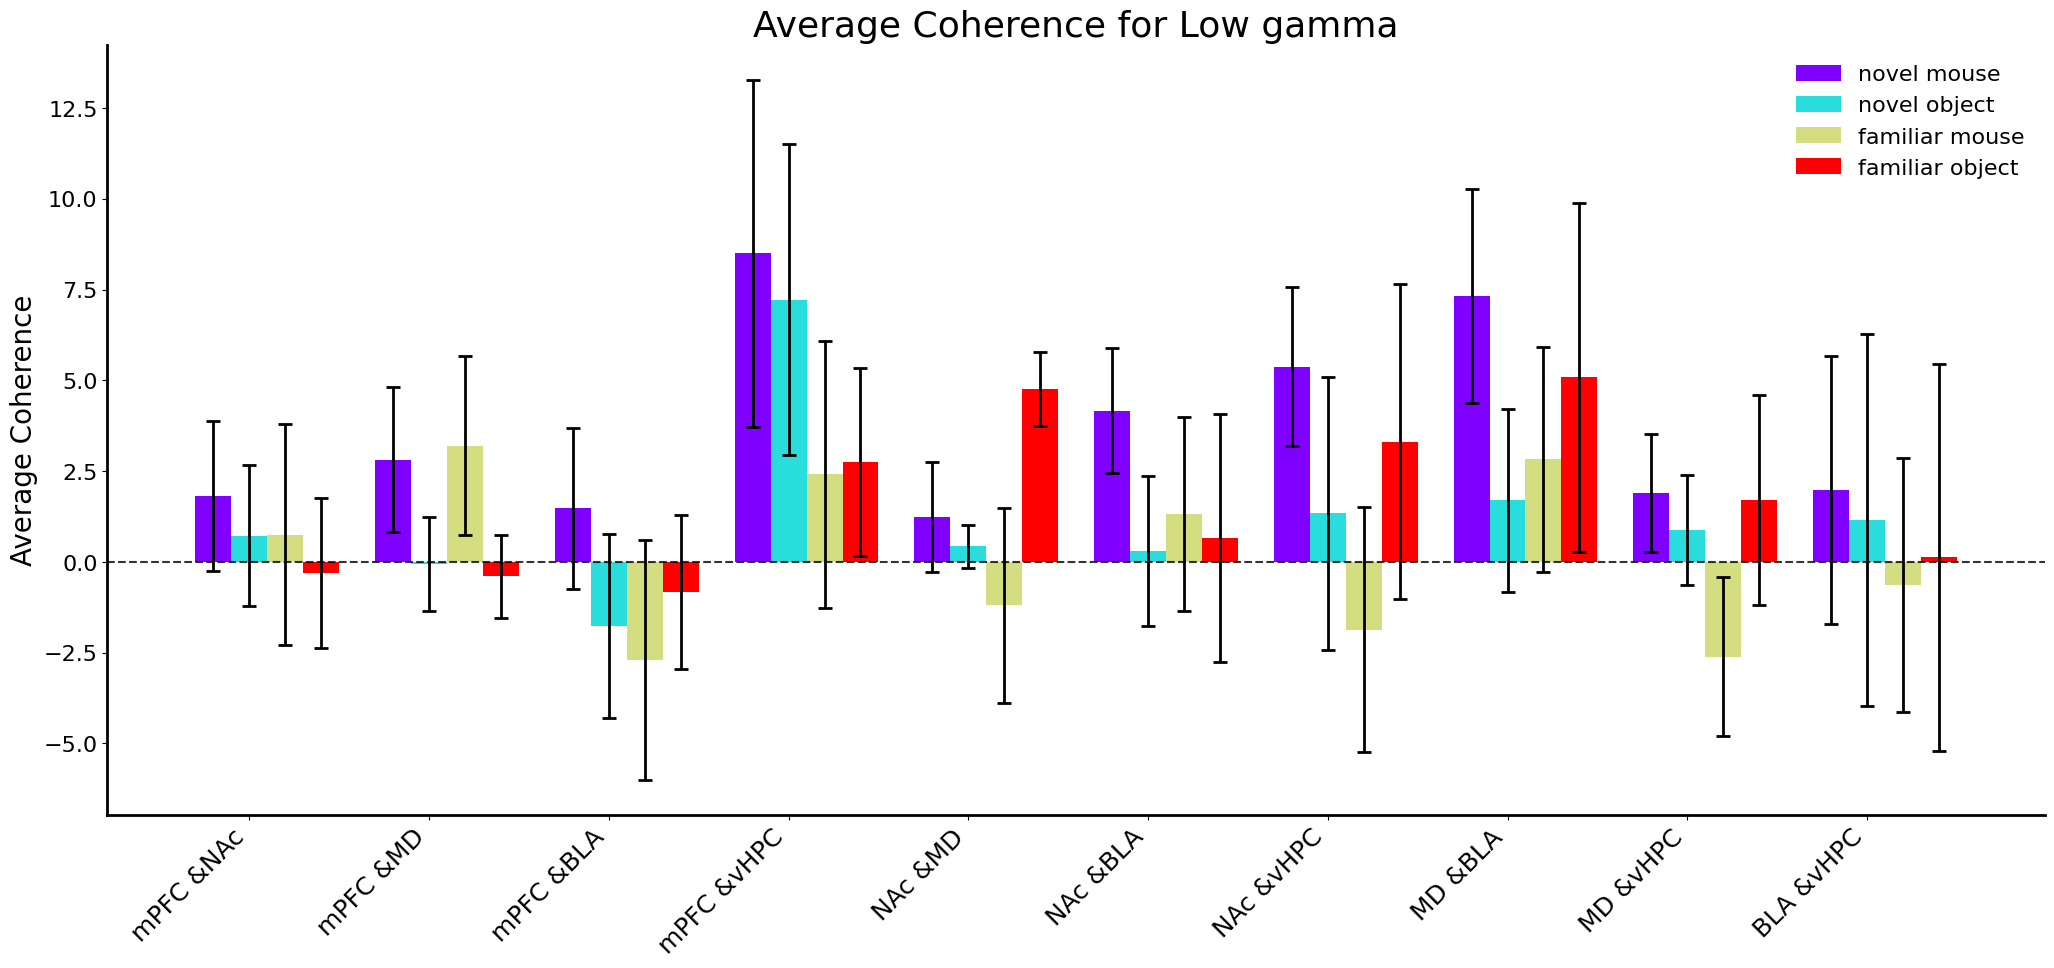

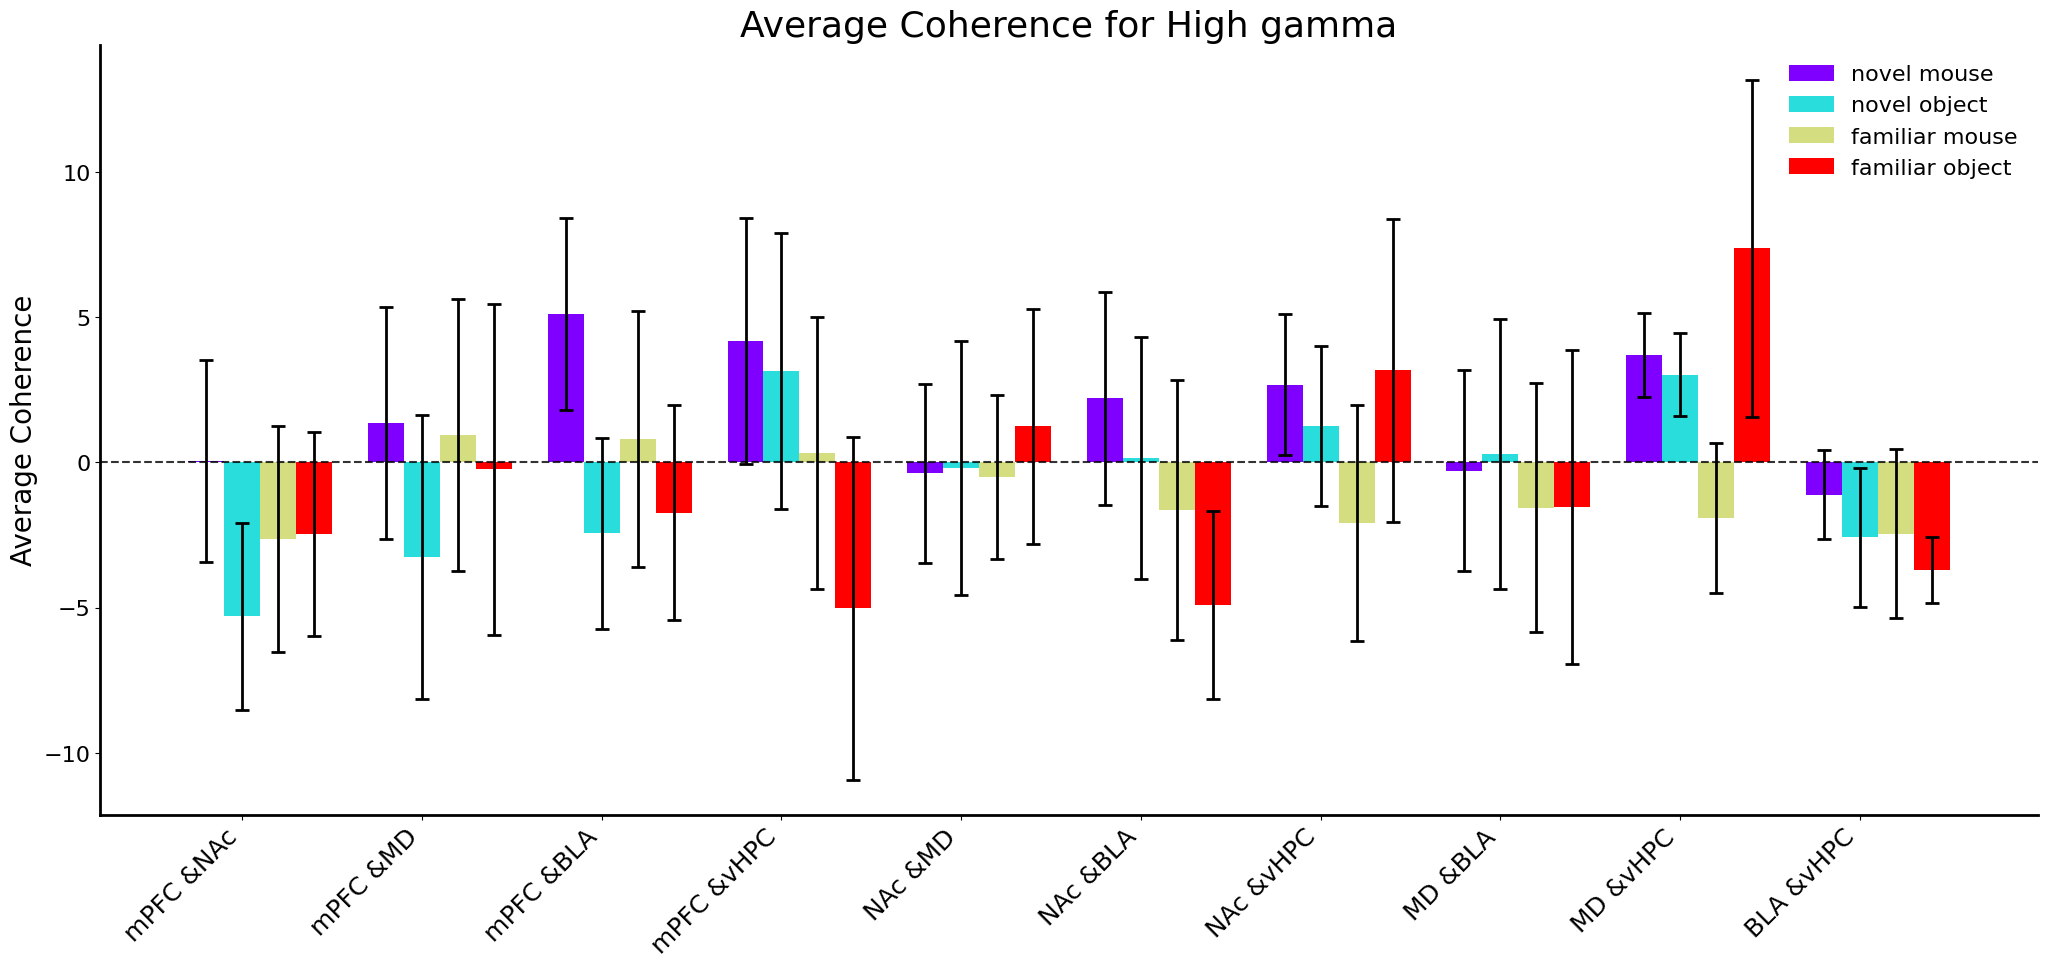

In [8]:
lfplt.event_coherence_bar(object_collection, events =  ['novel mouse', 'novel object', 'familiar mouse', 'familiar object'], baseline = ['baseline', 'baseline', 'baseline', 'baseline'])

In [ ]:
def plot_coherence_comparison(lfp_collection, all_event_averages, regions=None, freq_range=None):
    """
    Plots comparison of different coherence calculation methods for each brain region pair.
    Only plots the upper triangle of region pairs (i,j) where i < j.
    
    Parameters:
    -----------
    lfp_collection : object
        Collection of LFP recordings
    all_event_averages : dict
        Dictionary of dictionaries with event averages for each mode
    regions : list, optional
        List of brain regions to plot
    freq_range : list, optional
        Frequency range to plot [min, max]
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats
    
    if regions is None:
        regions = list(lfp_collection.brain_region_dict.keys())
    if freq_range is None:
        freq_range = [1, 101]
    
    # Get number of coherence calculation methods (modes)
    n_modes = len(all_event_averages)
    
    # Get the events (assuming all modes have the same events)
    first_mode_key = list(all_event_averages.keys())[0]
    events = list(all_event_averages[first_mode_key].keys())
    
    # Generate all region pairs (upper triangle only)
    region_pairs = []
    for i in range(len(regions)):
        for j in range(i+1, len(regions)):  # Only upper triangle
            region_pairs.append((regions[i], regions[j]))
    
    # Create figure with subplots - One row per region pair, one column per mode
    fig, axes = plt.subplots(len(region_pairs), n_modes, figsize=(12, len(region_pairs)*2))
    if len(region_pairs) == 1:
        axes = axes.reshape(1, -1)
    
    # For each region pair (rows)
    for pair_idx, (region1, region2) in enumerate(region_pairs):
        region1_index = lfp_collection.brain_region_dict[region1]
        region2_index = lfp_collection.brain_region_dict[region2]
        
        # Find global max y-value for consistent scaling across all plots in this row
        y_max = 0
        for mode_title, event_averages_dict in all_event_averages.items():
            for event, averages in event_averages_dict.items():
                event_average = np.nanmean(averages, axis=0)
                event_sem = stats.sem(averages, axis=0, nan_policy="omit")
                try:
                    y = event_average[freq_range[0]:freq_range[1], region1_index, region2_index]
                    y_sem = event_sem[freq_range[0]:freq_range[1], region1_index, region2_index]
                    y_max = max(y_max, np.nanmax(y + y_sem))
                except IndexError:
                    pass
        
        # For each coherence calculation method (columns)
        for mode_idx, (mode_title, event_averages_dict) in enumerate(all_event_averages.items()):
            if len(region_pairs) == 1:
                ax = axes[mode_idx]
            else:
                ax = axes[pair_idx, mode_idx]
            
            # Plot each event for this mode and region pair
            for event, averages in event_averages_dict.items():
                # Calculate mean and SEM across trials
                event_average = np.nanmean(averages, axis=0)
                event_sem = stats.sem(averages, axis=0, nan_policy="omit")
                
                try:
                    # Extract data for the selected frequency range and region pair
                    y = event_average[freq_range[0]:freq_range[1], region1_index, region2_index]
                    y_sem = event_sem[freq_range[0]:freq_range[1], region1_index, region2_index]
                    x = range(freq_range[0], freq_range[1])
                    
                    # Plot mean and SEM
                    (line,) = ax.plot(x, y, label=event)
                    ax.fill_between(x, y - y_sem, y + y_sem, alpha=0.2, color=line.get_color())
                except IndexError:
                    print(f'No events of type {event} for {region1}-{region2}') 
            
            # Set titles and labels
            if pair_idx == 0:
                ax.set_title(mode_title)
            if mode_idx == 0:
                ax.set_ylabel(f"{region1} - {region2}\nCoherence")
            if pair_idx == len(region_pairs) - 1:
                ax.set_xlabel("Frequency (Hz)")
            if mode_idx == n_modes - 1:
                ax.legend(bbox_to_anchor=(1, 1))
            
            # Set y-axis limit to be consistent for this region pair
            ax.set_ylim(0, y_max * 1.1)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.suptitle("Coherence Comparison Across Calculation Methods by Brain Region Pairs", fontsize=16)
    plt.subplots_adjust(top=0.93)
    plt.show()

def plot_granger_comparison(lfp_collection, all_event_averages, regions=None, freq_range=None):
    """
    Plots comparison of different Granger causality calculation methods for each brain region pair.
    Plots all directional pairs (i,j) and (j,i) to show both directions of causality.
    
    Parameters:
    -----------
    lfp_collection : object
        Collection of LFP recordings
    all_event_averages : dict
        Dictionary of dictionaries with event averages for each mode
    regions : list, optional
        List of brain regions to plot
    freq_range : list, optional
        Frequency range to plot [min, max]
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats
    
    if regions is None:
        regions = list(lfp_collection.brain_region_dict.keys())
    if freq_range is None:
        freq_range = [1, 101]
    
    # Get number of Granger calculation methods (modes)
    n_modes = len(all_event_averages)
    
    # Get the events (assuming all modes have the same events)
    first_mode_key = list(all_event_averages.keys())[0]
    events = list(all_event_averages[first_mode_key].keys())
    
    # Generate all directed region pairs (exclude self-pairs)
    region_pairs = []
    for i in range(len(regions)):
        for j in range(len(regions)):
            if i != j:  # Exclude self-pairs
                region_pairs.append((regions[i], regions[j]))
    
    # Create figure with subplots - One row per region pair, one column per mode
    fig, axes = plt.subplots(len(region_pairs), n_modes, figsize=(12, len(region_pairs)*2))
    if len(region_pairs) == 1:
        axes = axes.reshape(1, -1)
    
    # For each region pair (rows)
    for pair_idx, (region1, region2) in enumerate(region_pairs):
        region1_index = lfp_collection.brain_region_dict[region1]
        region2_index = lfp_collection.brain_region_dict[region2]
        
        # Find global max y-value for consistent scaling across all plots in this row
        y_max = 0
        for mode_title, event_averages_dict in all_event_averages.items():
            for event, averages in event_averages_dict.items():
                event_average = np.nanmean(averages, axis=0)
                event_sem = stats.sem(averages, axis=0, nan_policy="omit")
                try:
                    y = event_average[freq_range[0]:freq_range[1], region1_index, region2_index]
                    y_sem = event_sem[freq_range[0]:freq_range[1], region1_index, region2_index]
                    y_max = max(y_max, np.nanmax(y + y_sem))
                except IndexError:
                    pass
        
        # For each Granger calculation method (columns)
        for mode_idx, (mode_title, event_averages_dict) in enumerate(all_event_averages.items()):
            if len(region_pairs) == 1:
                ax = axes[mode_idx]
            else:
                ax = axes[pair_idx, mode_idx]
            
            # Plot each event for this mode and region pair
            for event, averages in event_averages_dict.items():
                # Calculate mean and SEM across trials
                event_average = np.nanmean(averages, axis=0)
                event_sem = stats.sem(averages, axis=0, nan_policy="omit")
                
                try:
                    # Extract data for the selected frequency range and region pair
                    y = event_average[freq_range[0]:freq_range[1], region1_index, region2_index]
                    y_sem = event_sem[freq_range[0]:freq_range[1], region1_index, region2_index]
                    x = range(freq_range[0], freq_range[1])
                    
                    # Plot mean and SEM
                    (line,) = ax.plot(x, y, label=event)
                    ax.fill_between(x, y - y_sem, y + y_sem, alpha=0.2, color=line.get_color())
                except IndexError:
                    print(f'No events of type {event} for {region1}->{region2}') 
            
            # Set titles and labels
            if pair_idx == 0:
                ax.set_title(mode_title)
            if mode_idx == 0:
                ax.set_ylabel(f"{region1} → {region2}\nGranger Causality")
            if pair_idx == len(region_pairs) - 1:
                ax.set_xlabel("Frequency (Hz)")
            if mode_idx == n_modes - 1:
                ax.legend(bbox_to_anchor=(1, 1))
            
            # Set y-axis limit to be consistent for this region pair
            ax.set_ylim(0, y_max * 1.1)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.suptitle("Granger Causality Comparison Across Calculation Methods by Brain Region Pairs", fontsize=16)
    plt.subplots_adjust(top=0.93)
    plt.show()

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/LFP_analysis.py:128: RuntimeWarning: Mean of empty slice
  event_snippet = np.nanmean(event_snippet, axis=0)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/LFP_analysis.py:380: RuntimeWarning: Mean of empty slice
  baseline_recording = np.nanmean(np.array(baseline_averages), axis=0)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/LFP_analysis.py:455: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[:, 0:4, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/LFP_analysis.py:456: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[:, 4:13, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/LFP_analysis.py:458: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[:, 13:

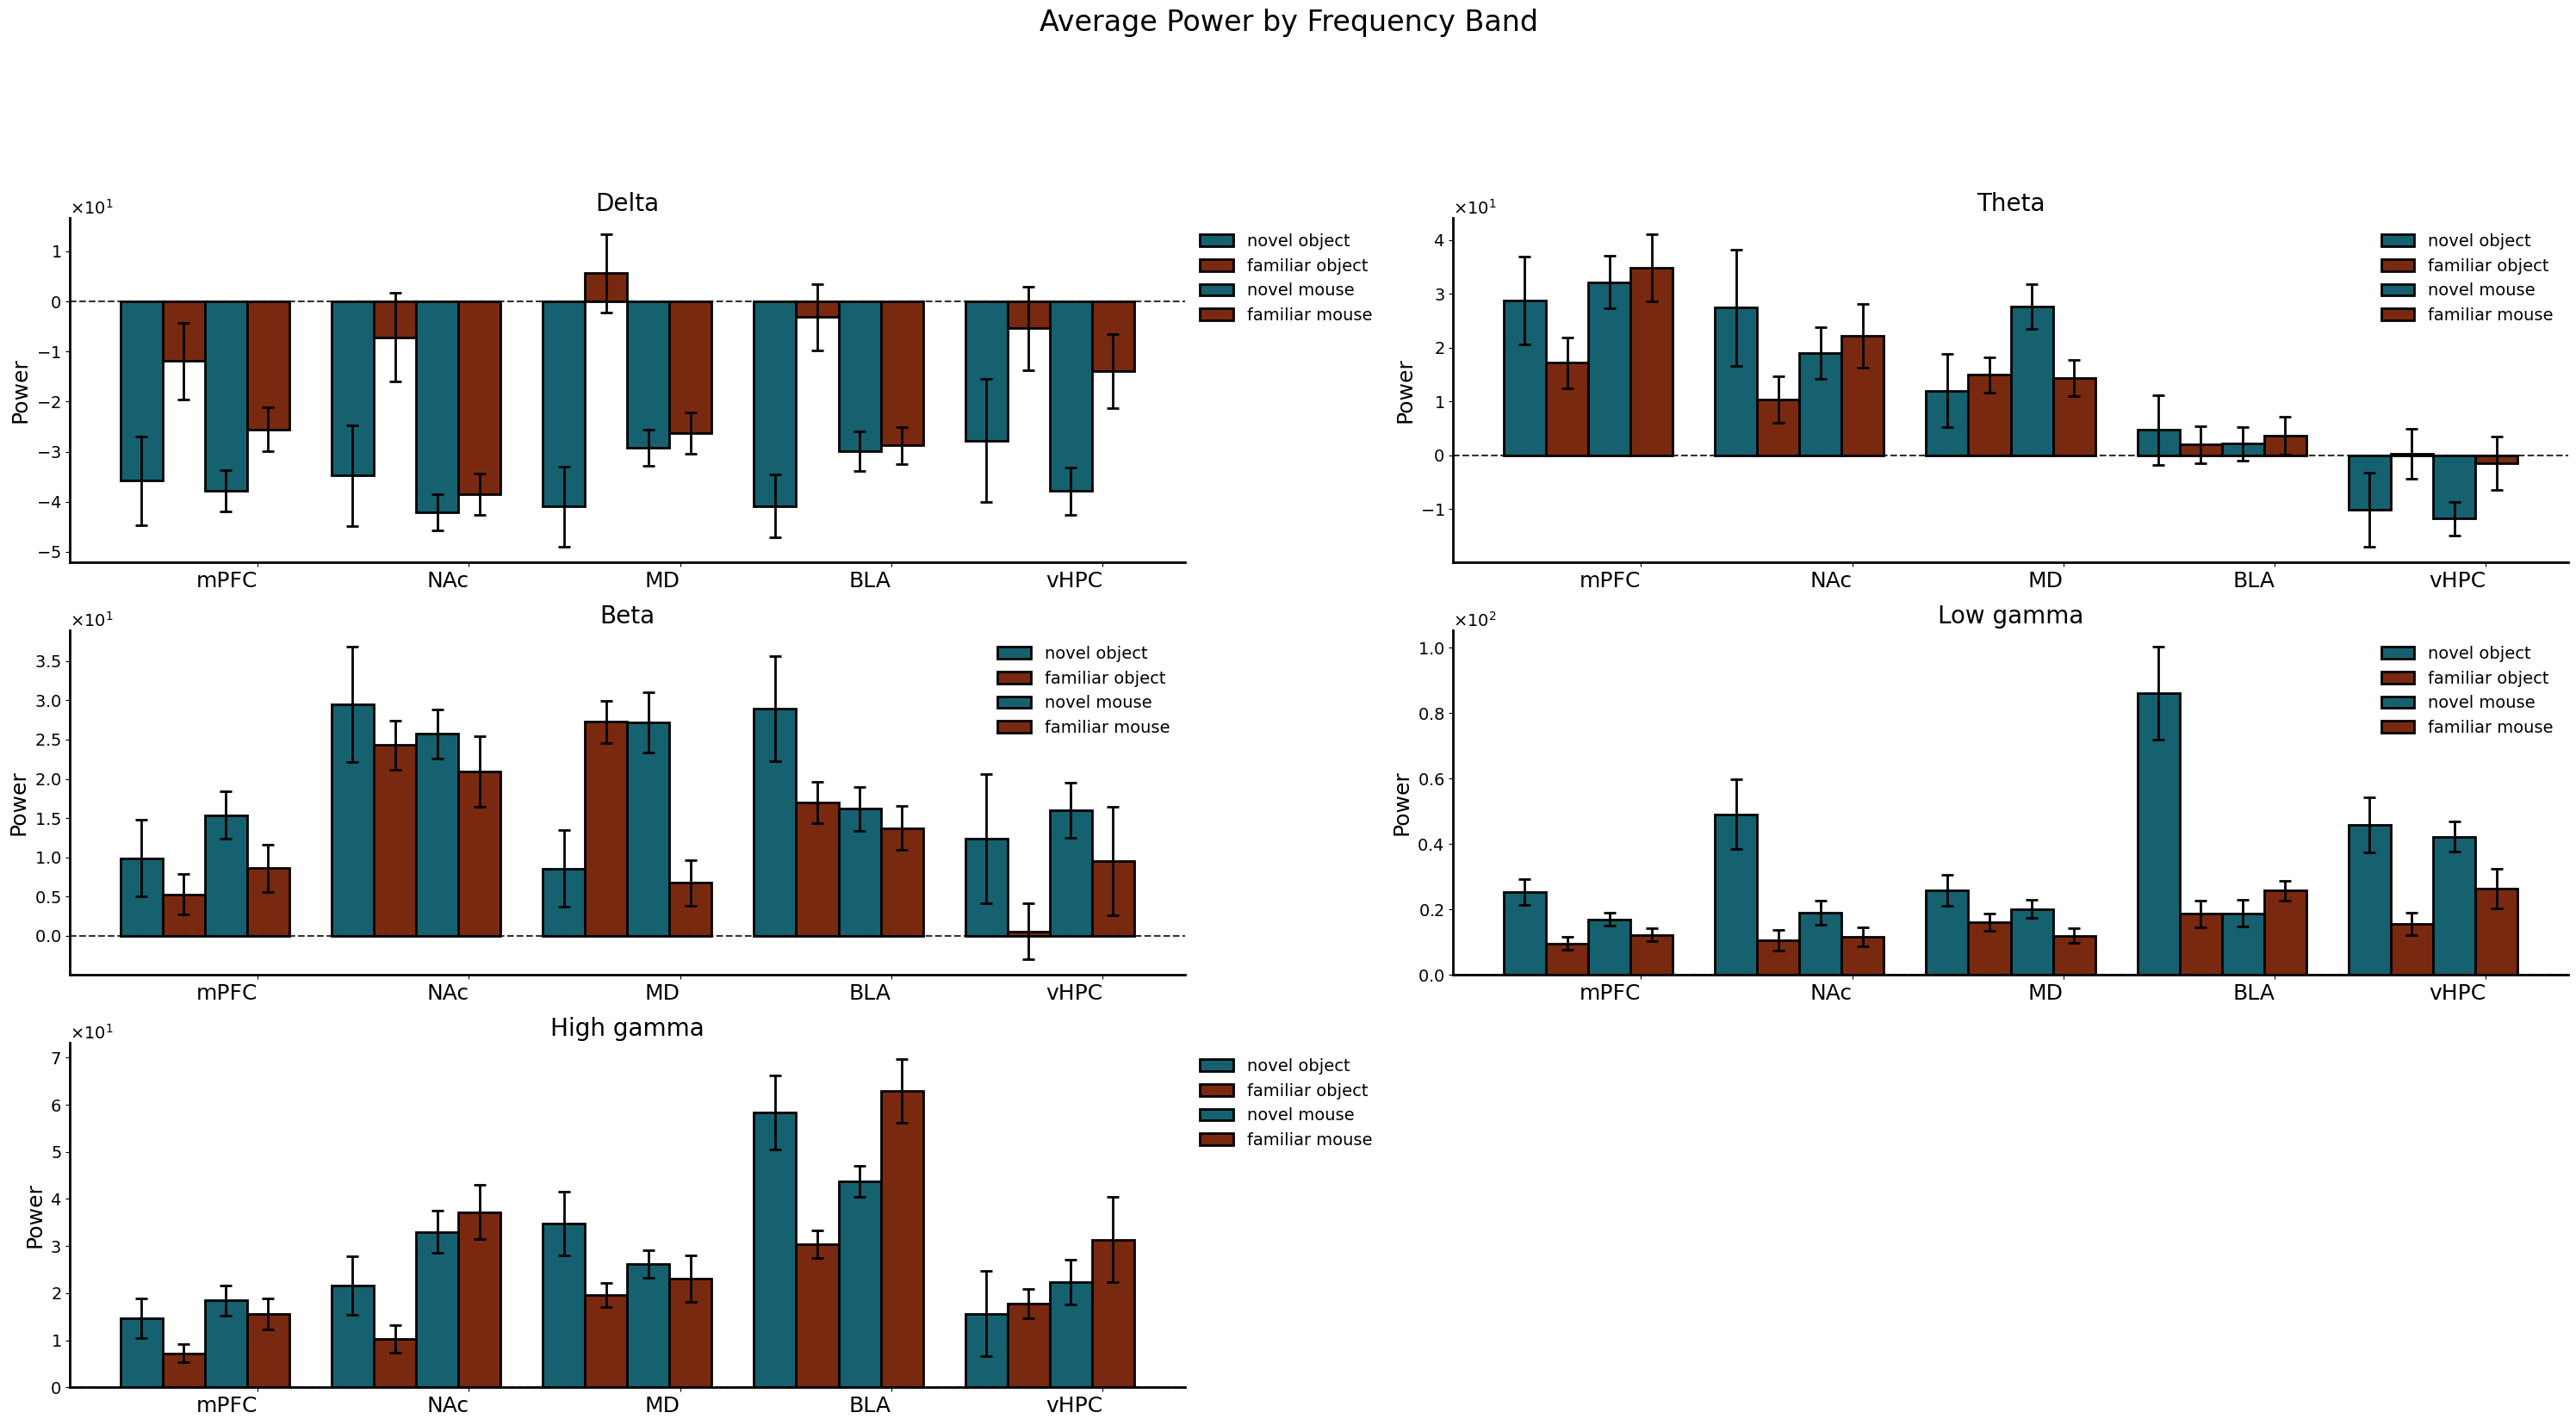

In [ ]:
novel_power_averages = lfplt.average_events(object_collection, events = ['novel object'], baseline = 'baseline', mode = 'power', plot = False)
cagemate_power_averages = lfplt.average_events(object_collection, events = ['familiar object'], baseline = 'baseline', mode = 'power', plot = False)
familiar_power_averages = lfplt.average_events(object_collection, events = ['novel mouse'], baseline = 'baseline', mode = 'power', plot = False)
empty_power_averages = lfplt.average_events(object_collection, events = ['familiar mouse'], baseline = 'baseline', mode = 'power', plot = False)
power_dict = {'novel object':cagemate_power_averages,
              'familiar object': novel_power_averages, 
              'novel mouse': familiar_power_averages,
              'familiar mouse':empty_power_averages}

colors = ['#15616F', '#792910','#15616F', '#792910']
plot_averages(power_dict, object_collection, colors = colors, bar_width = .2)

      